# What makes a movie successful?

## Library imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy
import sklearn.model_selection as sk
import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [407]:
def split_str_list(x):
    """Function to split comma seperated string into array type data"""
    if type(x) == str and x != "" and x != "\\N":
        return x.split(',')
    else:
        return None

def cast_count(cast_age):
    """Function to return the count of the cast array"""
    return len(cast_age[~np.isnan(cast_age)])

def keep_numbers(revenue):
    """Function to convert revenue string to a number, we only do it for revenue in dollars
    Because we did not manage to find conversion rates for movies from <2000"""
    if isinstance(revenue, float):
        return np.nan
    if revenue == None or revenue[0] != '$':
        return np.nan
    return int(re.sub("[^0-9]","", str(revenue)))

def bootstrap_mean_ci(data, percentile, n_sample):
    '''Function to compute the bootstrap confidence interval for the mean'''
    sample_means = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_means.append(np.nanmean(sample))
    
    return [np.round(np.percentile(sample_means, percentile), 3), \
            np.round(np.percentile(sample_means, 100-percentile), 3)]

def bootstrap_median_ci(data, percentile, n_sample):
    '''Function to compute the bootstrap confidence interval for the median'''
    sample_medians = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_medians.append(np.nanmedian(sample))
    
    return [np.round(np.percentile(sample_medians, percentile), 3), \
            np.round(np.percentile(sample_medians, 100-percentile), 3)]

def normalize_inflation(revenue, year):
    """Take inflation into account, no data available before 1960"""
    if np.isnan(revenue) or np.isnan(year) or year < 1960:
        return np.nan
    return ep.normalize(amount=revenue, region="US", from_year=year, to_year="latest", base_currency="USD")

normalize_inflation = np.vectorize(normalize_inflation)

def df_crossjoin(df):
    """Function to cross join a dataframe with itself"""
    df['tmpkey'] = 1
    res = pd.merge(df, df, on='tmpkey').drop('tmpkey', axis=1)
    df.drop('tmpkey', axis=1, inplace=True)
    return res


def jaccard_similarity(list1, list2):
    """Function to compute the Jaccard similarity for 2 lists"""
    s1 = set(list1)
    s2 = set(list2)
    return np.round(len(s1.intersection(s2)) / len(s1.union(s2)),2)

def no_null(year):
    """Function replacing missing years with 3000 which is necessary for the actors score"""
    if (np.isnan(year)):
        return 3000
    else:
        return year
    

def actor_score(categories,w_n):
    """This function computes score based on a weighted sum depending on the column (Winner\ Nominee)"""
    """and the cateory of the award."""
    
    if(len(categories) == 0):
        return 0
    else:
        #Giving weights to awards
        awards_weights = dict({'Oscar':10 ,'Golden Globe':9,'Palme d Or':8,'BAFTA Film Award':7\
                             ,'Golden Berlin Bear':6,'Filmfare Award':5,'European Film Award':4,\
                             'Golden Leopard':3,'Grand Jury Prize':2,'Golden Lion':1})
        winner = dict({'Nominee':1,'Winner':2})
        score = 0
        
        for category, win in zip(categories,w_n):
            score = score+winner[win]*awards_weights[category]
        return score 
    
def cumulated_score(df_actors, cast, year):
    """Cumulated score takes as an input the dataframe containing actors awards, 
       the hole cast of a movie and a year
       and outputs the cumulated score : the sum of actor's scores present in the cast list:"""
    #if the cast="[]"
    if len(cast) == 0:
        return 0
    #if the startYear of the movie is missing the cumulated score will return 0
    if (str(year) == '\\N'):
        return 0
    else:
        total_score=0
        for actor in cast:
            total_score=total_score+actor_year_score(df_actors,actor,year)
        return total_score    
    
def actor_year_score(df, nconst, year):
    """This function takes as imput the dataframe containing the awards of each actor, 
       the name of a specific actor and a yearIt return the actor score of the given nconst before that year"""
    n_df = df[(df['nconst'] == nconst) & (df['year'] < year)]
    
    return actor_score(n_df['category2'], n_df['w_n'])

def director_score(df,director, year):
    """Computes the cumulated movies awards for a given director before a given year """
    df_dir = df[(df['directors'] == director) & (df['startYear'] < year)]
    return df_dir['wins'].sum()

The data for the project was obtained in 2 ways. 
* Data sets made available by IMDB
* Web scraping IMDB.com site

**_The Python code used for web scraping additional information on movies and actors are included in the Annex section_**

We now load both sources of data and perform a cleaning on the data set provided from IMDB

### Data loading

In [3]:
# Load data pickles of scraped data
movies_scraped = pd.read_pickle('pickles/complete_movies.pkl')
cast_scraped = pd.read_pickle('pickles/complete_cast.pkl')
actors_awards = pd.read_pickle('pickles/complete_stars_awards.pkl')

# Load datasets downloaded from the imdb website
movies_file = pd.read_csv('data/title.basics.tsv.gz', 
                          sep='\t', na_values= '\\N', 
                          dtype={'isAdult': 'int32'},
                          converters={'genres': split_str_list})
people_file = pd.read_csv('data/name.basics.tsv.gz', 
                          sep='\t', 
                          converters={'primaryProfession': split_str_list}, 
                          na_values= '\\N')
movie_ratings = pd.read_csv("data/title.ratings.tsv.gz", sep='\t')
movie_akas = pd.read_csv("data/title.akas.tsv.gz", sep='\t')
country_codes = pd.read_csv('data/countries.csv')
crew = pd.read_csv('data/title.crew.tsv',sep='\t')

In [4]:
print('movies_scarped length : {}'.format(len(movies_scraped)))
print('cast_scarped length : {}'.format(len(cast_scraped)))
print('movies_file length : {}'.format(len(movies_file)))
print('people_file length : {}'.format(len(people_file)))
print('movie_ratings length : {}'.format(len(movie_ratings)))
print('movies_akas length : {}'.format(len(movie_akas)))
print('country_codes length : {}'.format(len(country_codes)))

movies_scarped length : 537913
cast_scarped length : 537483
movies_file length : 6277849
people_file length : 9711022
movie_ratings length : 1283158
movies_akas length : 19146814
country_codes length : 251


In [6]:
movies_scraped.duplicated(subset=['tconst']).value_counts()

False    537913
dtype: int64

### Data cleaning and preperation

The data type of the releaseDate column of the scraped dataset is string. So we change the datatype to datetime64

In [7]:
movies_scraped = movies_scraped.astype({'releaseDate': 'datetime64'})

We noticed that the runtimeMinutes column in the same containes a mix of float and string values. We change them all to floats.

In [10]:
# Some runtime values are in strings. Convert them to numerics as well
movies_file.runtimeMinutes = pd.to_numeric(movies_file.runtimeMinutes, errors='coerce')

We looked at the startYear of the movies_file and we observed that there are some movies that have their startYear in the future. This is not an anomaly as movie relase dates are known before hand. We will however not consider them in our analysis since there is no way to tell if they will be successful or not. 

In [12]:
# Retain only the titles that have startYear before 2019
movies_file = movies_file[(movies_file.startYear < 2019) | (movies_file.startYear.isna())]

We also looked at the genres column of the movies_file and noticed that some of them still contains string valus that represent 'Null' and also some empty strings. The converter 'split_str_list' applied when reading the dataset replaces these values with None.

We merge the movie information from the IMDB titles dataset file with the scraped movies informations to check if the years from the scraping and the imdb files are the same.

In [13]:
movies_file = movies_file[movies_file['titleType'] == 'movie']

# Drop columns titleType since we do not need it after filtering only the movies and 
# endYear since it does not mean anything for movies as it's used to tell us when a TV show finished
movies_file = movies_file.drop(['titleType', 'endYear'], axis=1)
movies = movies_scraped.merge(movies_file, how='outer', on='tconst')

movies['releaseYear'] = movies['releaseDate'].apply(lambda x: np.nan if (x == None) else x.year)

diffs = (movies['releaseYear'] - movies['startYear'])
print('There are {} movies where the scraped year is not the same as in the files'\
      .format((diffs != 0.0).sum()-(diffs.isna()).sum()))

There are 32390 movies where the scraped year is not the same as in the files


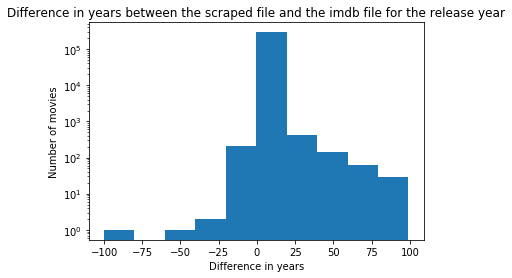

In [18]:
plt.hist(diffs[~np.isnan(diffs)]);
plt.yscale('log', nonposy='clip')
plt.title('Difference in years between the scraped file and the imdb file for the release year');
plt.ylabel('Number of movies');
plt.xlabel('Difference in years');

We can see that a majority of the records have the same year which is good. The ones showing differences could be due to the fact that the field releaseDate shown in the IMDB website might not necessarily be the actual start date of the movie. 

We make a new feature; when the year is missing in the scraped file we take the year from the downloaded dataset

In [19]:
movies['year'] = np.where(np.isnan(movies['startYear']), movies['releaseYear'], movies['startYear'])

We looked at the birthYear column of the people_file to see if the years are plausible and noticed that it contains values starting from 4 which does not make sense. So we set NaN at cells where the birthYear is less than 1800.

In [20]:
people_file['birthYear'] = np.where(people_file['birthYear'] < 1800, np.nan, people_file['birthYear'])

We now merge the cast information to the movies dataset.

In [21]:
movies = movies.merge(cast_scraped, how = 'outer', on = 'tconst')

We compute the age of the cast at the time they appeared on the movie

In [22]:
people_file = people_file.explode('primaryProfession')
movies_cast = movies[['tconst', 'cast', 'year']].explode('cast')
people_year = people_file.drop(['primaryName', 'deathYear', 'primaryProfession', 'knownForTitles'], axis=1)
people_year = people_year.drop_duplicates()
movies_cast = movies_cast.merge(people_year, how='inner', left_on = 'cast', right_on = 'nconst')

We introduce the Age variable, we compute it from the Year of the movies file/scraping and the birthYear of people file

In [23]:
movies_cast['age'] = movies_cast['year'] - movies_cast['birthYear']

In [24]:
print("Number of instances actors had negative age: {0}".format((movies_cast['age'] < 0).sum()))
print("Number of instances actors had age above 100: {0}".format((movies_cast['age'] > 100).sum()))

Number of instances actors had negative age: 530
Number of instances actors had age above 100: 6615


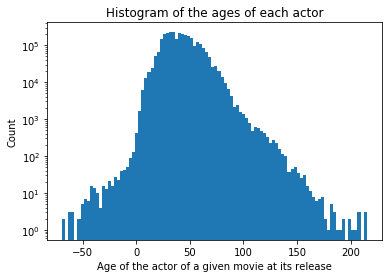

In [25]:
ages = movies_cast['age'].values
plt.hist(ages[~np.isnan(ages)], bins=100);
plt.yscale('log', nonposy='clip')
plt.title('Histogram of the ages of each actor');
plt.xlabel('Age of the actor of a given movie at its release');
plt.ylabel('Count');

In [26]:
cast_ages = movies_cast.groupby(['tconst'])['age'].agg([np.nanmedian, cast_count])
cast_ages = cast_ages.rename(columns={'nanmedian': 'age_median'})

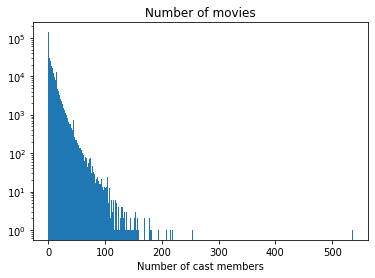

In [28]:
plt.hist(cast_ages['cast_count'], bins=500);
plt.yscale('log', nonposy='clip')
plt.title('Number of cast members');
plt.xlabel('Number of cast members');
plt.title('Number of movies');

We only take the information if we have more than 10 persons in the cast

In [29]:
cast_ages['credible_median'] = np.where(cast_ages['cast_count'] > 10, cast_ages['age_median'], np.nan)

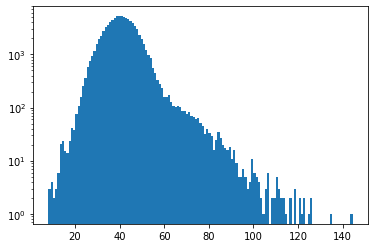

In [30]:
credible_median_ages = cast_ages['credible_median'].values
plt.hist(credible_median_ages[~np.isnan(credible_median_ages)], bins = 135);
plt.yscale('log', nonposy='clip')

We see that we do not have the negative age outliers but we still have suspiciously high values

In [31]:
cast_ages.nlargest(10, 'credible_median')

,age_median,cast_count,credible_median
tconst,,,
tt6454944,144.5,30.0,144.5
tt6490038,135.0,11.0,135.0
tt1646939,126.0,11.0,126.0
tt3587202,126.0,17.0,126.0
tt0212457,125.0,11.0,125.0
tt3188516,123.0,13.0,123.0
tt3526810,123.0,13.0,123.0
tt10443162,122.0,43.0,122.0
tt2161168,121.0,20.0,121.0


The high values come from recent documentaries using archive footage or reconstruction of very old films.

In [32]:
cast_ages.nsmallest(10, 'credible_median')

,age_median,cast_count,credible_median
tconst,,,
tt0201347,8.0,27.0,8.0
tt0008144,9.0,17.0,9.0
tt0110366,9.0,34.0,9.0
tt0007617,9.5,14.0,9.5
tt0009721,9.5,14.0,9.5
tt0117008,10.0,44.0,10.0
tt0124879,10.0,35.0,10.0
tt0007669,11.0,14.0,11.0
tt0022397,11.0,16.0,11.0


Legit values

Finally we merge the rating information as well into the movies dataframe

In [33]:
movies = movies.merge(movie_ratings, left_on='tconst', right_on='tconst', how='left')

The metascore column of the movies dataset has both NaN and None to represent missing values. Hence we make them all NaN.

In [34]:
clean_metascore = lambda x: np.nan if x == None else x
movies['metascore'] = movies['metascore'].apply(clean_metascore)
movies['metascore'] = movies['metascore'].astype(float)

# **** TODO **** check for all the other columns to fix mix of NaNs and Nones

The people_file dataset obtained from IMDB contains information about people of various related professions like Director, Sound Engineer, Actor, Actress etc. For some parts of the analysis we need only the actors and actresses and here we filter them out and prepare a seperate dataframe.

In [35]:
people_prof_exploded = people_file.explode('primaryProfession')
actors = people_prof_exploded[
        (people_prof_exploded.primaryProfession == 'actress') | (people_prof_exploded.primaryProfession == 'actor')]

# Creation of success metrics

We consider the success of the movies in 4 different aspects. Analysis will be carried out for each of these aspects separately. The 4 aspects are as follows.
* Awards
* Popularity
* Profit
* Metacritic score

Now we compute the respective set of successful movies for each of those aspects

### Awards

We define a metric to represent the success of a movie as a score in terms of its awards and nominations. Based on the intuition that an Oscar win is the most prestigious award a movie can ever get, we give a weight of 10 for Oscar awards. For any other awards we give a weight of 2 and all the nominations will receive a weight of 1. The weighted sum of these 3 aspects will be the **Recognition Score** of a movie.

In [36]:
OSCAR_WEIGHT = 10
WIN_WEIGHT = 2
NOMINATION_WEIGHT = 1
movies['recognition'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) \
                        + (movies.wins * WIN_WEIGHT)
recognized_movies = movies.sort_values('recognition', ascending=False)

Let us have a look at the distribution of the Recognition Scores computer for all the movies.

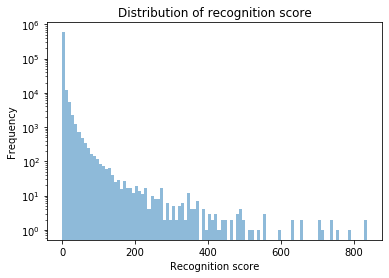

In [37]:
fig, ax = plt.subplots()
recognized_movies.recognition.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of recognition score')
ax.set_xlabel('Recognition score');

We can see that for a vast majority of the movies, either they have never got nominated for, or won any awards or IMDB does not have the award related information for those movies. So taking the movies with a Recognition Score of 0 for the comparison does not make sense. We will therefore only keep the movies that has a non-zero Recognition score and we will select the top 5% of those movies as the most successful movies in terms of awards recogntion.

In [38]:
CUT_OFF_THRESH = 0.05
nzero_recognized_movies = recognized_movies[recognized_movies.recognition > 0]
top_recognized_movies = nzero_recognized_movies[:int(len(nzero_recognized_movies) * CUT_OFF_THRESH)]
top_recognized_movies.reset_index(drop=True, inplace=True)

unrecognized_movies = pd.concat([
    nzero_recognized_movies[int(len(nzero_recognized_movies) * CUT_OFF_THRESH):],
    recognized_movies[recognized_movies.recognition == 0]])
unrecognized_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of awards: {0} out of {1}'\
      .format(len(top_recognized_movies), len(movies)))
print('Number of movies considered unsuccessful in terms of awards: {0} out of {1}'\
      .format(len(unrecognized_movies), len(movies)))

Number of movies considered successful in terms of awards: 3074 out of 610056
Number of movies considered unsuccessful in terms of awards: 606982 out of 610056


### Popularity  

As a direct measure of the popularity of a movie, we will consider the number of votes the movie has received on IMDB.

In [39]:
popular_movies = movies.dropna(subset=['numVotes'])\
                    .astype({'numVotes': 'int32'})\
                    .sort_values('numVotes', ascending=False)
print('Number of movies considered for the analysis after dropping mising values: {0} out of {1}'\
          .format(len(popular_movies), len(movies)))

recognized_movies = recognized_movies.merge(movie_ratings, on='tconst', how='left')

Number of movies considered for the analysis after dropping mising values: 312644 out of 610056


Let us first check the distribution of the number of votes on all the movies considered.

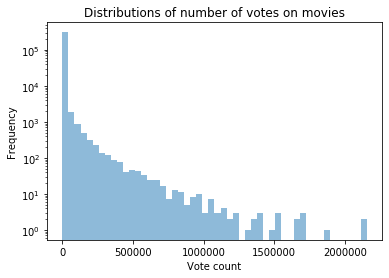

In [40]:
ax = popular_movies['numVotes'].plot.hist(bins=50, alpha=0.5)
ax.set_title('Distributions of number of votes on movies')
ax.set_xlabel('Vote count')
ax.set_yscale('log')

Here also we see that for a vast majority of the movies, the vote count is either missing or the movie did not get any votes at all on IMDB. Since a comparison between movies with 0 votes does not make sense, we will only use the movies that have atleast 1 vote and take the top 5% as the successful movies in terms of poluarity.

In [41]:
CUT_OFF_THRESH = 0.05
nzero_popular_movies = popular_movies[popular_movies.numVotes > 0]
top_popular_movies = nzero_popular_movies[:int(len(nzero_popular_movies) * CUT_OFF_THRESH)]
top_popular_movies.reset_index(drop=True, inplace=True)

unpopupar_movies = pd.concat([
    nzero_popular_movies[int(len(nzero_popular_movies) * CUT_OFF_THRESH):],
    popular_movies[popular_movies.numVotes == 0]])
unpopupar_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of popuarity: {0} out of {1}'.format(len(top_popular_movies), len(movies)))
print('Number of movies considered unsuccessful in terms of popularity: {0} out of {1}'.format(len(unpopupar_movies), len(movies)))

Number of movies considered successful in terms of popuarity: 15632 out of 610056
Number of movies considered unsuccessful in terms of popularity: 297012 out of 610056


### Revenue

Apart from movies missing their budget and wordwide gross information in the database, the currencies the amounts are represented in vastly differs. Converting different currencies to one currency would require the conversion rates that existed in the times the movie was produced and posseses a challenge. Hence, we will filter out the movies that have different currencies in the 'Budget' and 'WorldwideGross' fields and get the difference in the 2 amounts as a measure of success.

We only use the revenue expressed in US dollars (the majority) as it is hard to find conversion rates before 2000. We use the easymoney library to take into account the inflation.

In [42]:
recognized_movies['worldwideGross_adjusted'] = recognized_movies['worldwideGross'].apply(keep_numbers)
ep = EasyPeasy()
recognized_movies['worldwideGross_adjusted'] = normalize_inflation(recognized_movies['worldwideGross_adjusted'],\
                                                                   recognized_movies['year'])

In [320]:
check = pd.read_pickle('pickles/complete_movies.pkl')

In [325]:
check1 = check[['tconst', 'worldwideGross',]]

In [332]:
check2 = recognized_movies[['tconst', 'worldwideGross', 'worldwideGross_adjusted', 'year']]

In [333]:
check3 = check1.merge(check2, how='inner', on='tconst')

In [334]:
check3

,tconst,worldwideGross_x,worldwideGross_y,worldwideGross_adjusted,year
0,tt11379670,None,None,NaN,NaN
1,tt11347568,None,None,NaN,NaN
2,tt11238100,None,None,NaN,NaN
3,tt11269396,None,None,NaN,NaN
4,tt11379778,None,None,NaN,NaN
...,...,...,...,...,...
537908,tt4503096,"$421,624","$421,624",4.411229e+05,2016.0
537909,tt4500922,"$288,175,335","$288,175,335",2.881753e+08,2018.0
537910,tt4502426,None,None,NaN,2016.0
537911,tt4228338,None,None,NaN,2013.0


In [336]:
check3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537913 entries, 0 to 537912
Data columns (total 5 columns):
tconst                     537913 non-null object
worldwideGross_x           43971 non-null object
worldwideGross_y           43971 non-null object
worldwideGross_adjusted    43391 non-null float64
year                       470502 non-null float64
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [337]:
check3['worldwideGross_y_test'] = normalize_inflation(check3['worldwideGross_y'].apply(keep_numbers),\
                                                                   check3['year'])

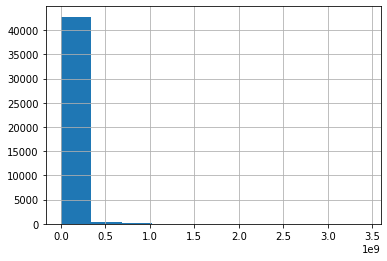

In [339]:
check3['worldwideGross_y_test'].

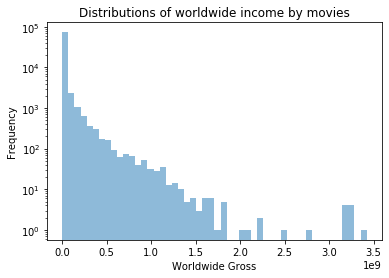

In [43]:
ax = recognized_movies['worldwideGross_adjusted'].plot.hist(bins=50, alpha=0.5)
ax.set_title('Distributions of worldwide income by movies')
ax.set_xlabel('Worldwide Gross')
ax.set_yscale('log')

Most of the movies have a gross 0. We will consider the top 10% highest income movies as financially successful movies.

In [44]:
movie_financial = recognized_movies.sort_values('worldwideGross_adjusted', ascending=False)
CUT_OFF_THRESH = 0.1
top_profit_movies = movie_financial[:int(len(movie_financial) * CUT_OFF_THRESH)]
top_profit_movies.reset_index(drop=True, inplace=True)

loss_movies = movie_financial[int(len(movie_financial) * CUT_OFF_THRESH):]
loss_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of profit: {0} out of {1}'\
      .format(len(top_profit_movies), len(movie_financial)))
print('Number of movies considered unsuccessful in terms of profit: {0} out of {1}'\
      .format(len(loss_movies), len(movie_financial)))

Number of movies considered successful in terms of profit: 75434 out of 754342
Number of movies considered unsuccessful in terms of profit: 678908 out of 754342


### Metacritic Score

The metascrit score is available as a column in the recognized_movies dataset

In [45]:
recognized_movies['metascore'] = recognized_movies['metascore'].astype(float)

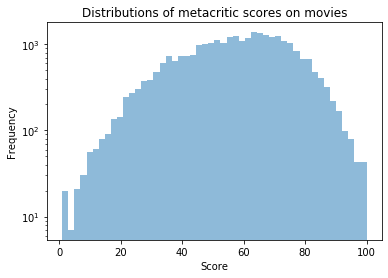

In [46]:
ax = recognized_movies['metascore'].plot.hist(bins=50, alpha=0.5)
ax.set_title('Distributions of metacritic scores on movies')
ax.set_xlabel('Score')
ax.set_yscale('log')

We see the distribution is kind of skewed normal plot with the peak around a score of 60 to 70 out of 100.

In [48]:
movie_meta = recognized_movies.sort_values('metascore', ascending=False)
CUT_OFF_THRESH = 0.1
top_meta_movies = movie_meta[:int(len(movie_meta) * CUT_OFF_THRESH)]
top_meta_movies.reset_index(drop=True, inplace=True)

low_meta_movies = movie_meta[int(len(movie_meta) * CUT_OFF_THRESH):]
low_meta_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of metascore: {0} out of {1}'\
      .format(len(top_meta_movies), len(movie_meta)))
print('Number of movies considered unsuccessful in terms of metascore: {0} out of {1}'\
      .format(len(low_meta_movies), len(movie_meta)))

Number of movies considered successful in terms of metascore: 75434 out of 754342
Number of movies considered unsuccessful in terms of metascore: 678908 out of 754342


# Data Analysis

## Age

### Awards Metric based comparison

In [49]:
recognized_movies = recognized_movies.merge(cast_ages, how='left', left_on='tconst', right_index=True)
recognized_movies = recognized_movies.drop_duplicates(subset=['tconst'])

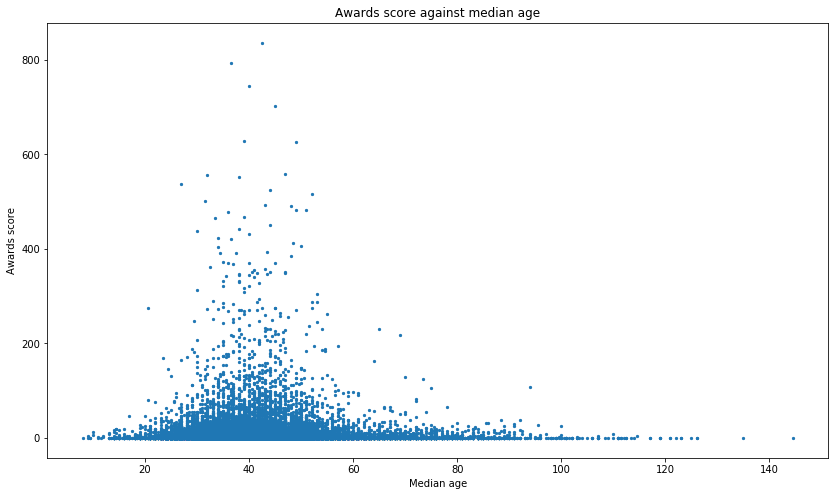

In [51]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against median age") 

#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

# **** TODO **** numVotes is added twice to the df somehow make it numVotes_X and numVotes_Y. 

In [53]:
#recognized_movies.drop(['numVotes_y', 'averageRating_y'], axis=1, inplace=True)
#recognized_movies.rename(columns={'numVotes_x': 'numVotes', 'averageRating_x': 'averageRating'}, inplace=True)

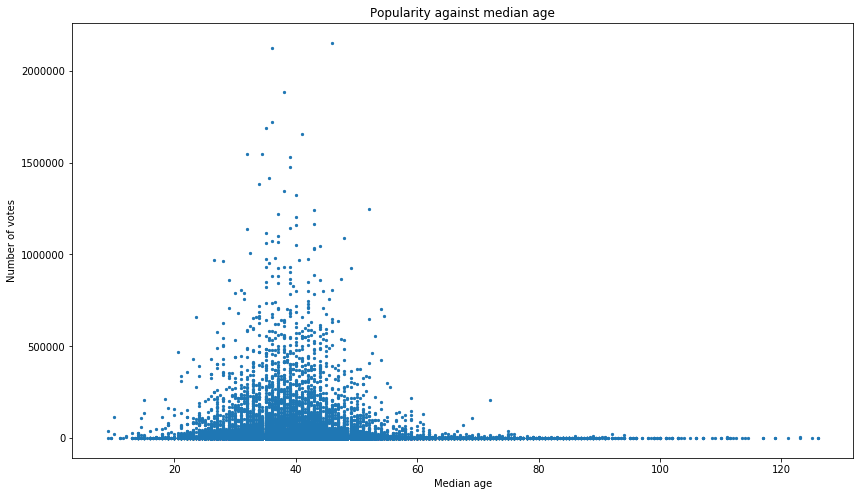

In [54]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against median age")  
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Number of votes');

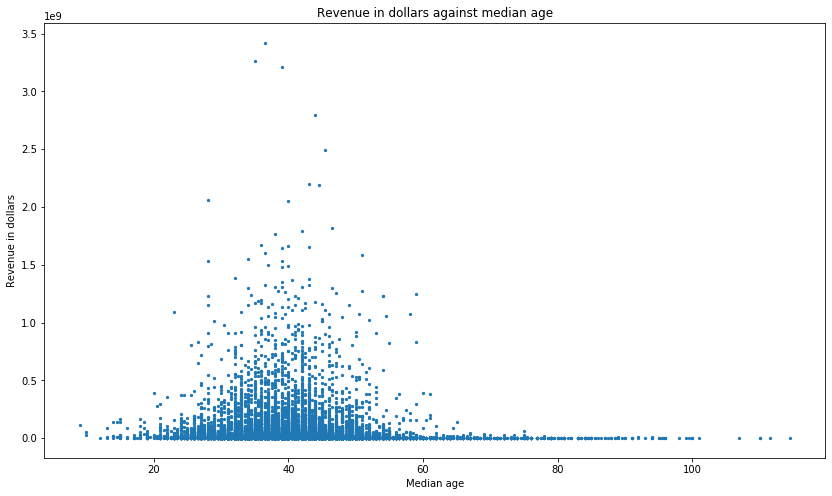

In [55]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against median age")
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Revenue in dollars');

In [ ]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['metascore'], s=5);

plt.title("Critics score against median age")
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Critics score');

It is hard to get some insightful information from the scatter plots. We see a higher score for median ages around 40 but this could be explained by the fact that most of the movies have young cast and hence there are more movies with a median cast age of 40. So we will now try to go more in-depth with more statistics for some age intervals.

In [57]:
intervals = np.arange(20, 90, 10)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 150)
movies_stats = recognized_movies.groupby(pd.cut(recognized_movies['credible_median'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted', 'metascore']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats = movies_stats.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [58]:
movies_stats['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",196,3.005102,6.849666,0,47,0,"[2.209, 3.781]","[0.0, 0.0]",3,8.5,17.50,28.90
"(20, 30]",5947,3.270220,15.657508,0,538,0,"[2.937, 3.613]","[0.0, 0.0]",0,8.0,16.70,51.00
"(30, 40]",37530,3.387557,18.201473,0,794,0,"[3.232, 3.543]","[0.0, 0.0]",0,7.0,16.00,57.00
"(40, 50]",38696,3.160430,17.263220,0,836,0,"[3.017, 3.298]","[0.0, 0.0]",0,6.0,15.00,58.05
"(50, 60]",6595,3.576346,17.319608,0,517,0,"[3.238, 3.928]","[0.0, 0.0]",0,8.0,17.00,64.06
"(60, 70]",1138,3.572935,14.106906,0,230,0,"[2.934, 4.297]","[0.0, 0.0]",0,9.0,17.00,57.00
"(70, 80]",552,3.358696,10.548219,0,125,0,"[2.638, 4.1]","[0.0, 0.0]",2,10.0,17.00,49.90
"(80, 150]",346,2.901734,8.503479,0,108,0,"[2.246, 3.708]","[0.0, 0.0]",0,10.0,17.75,31.55


In [59]:
movies_stats['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",181.0,12885.011050,35129.510783,7.0,214105.0,489.0,"[8707.736, 17422.903]","[331.975, 626.0]",4057.00,30337.0,81642.00,170016.40
"(20, 30]",5238.0,11038.288660,50314.131091,5.0,971031.0,237.0,"[9898.488, 12199.332]","[222.0, 260.0]",2018.25,17143.3,49202.00,230295.82
"(30, 40]",32808.0,11125.735278,62652.436359,5.0,2126738.0,173.0,"[10580.74, 11698.796]","[168.0, 179.0]",1212.25,10606.6,42928.00,248537.98
"(40, 50]",34406.0,6987.121229,44162.728704,5.0,2153889.0,137.0,"[6592.923, 7366.039]","[134.0, 141.0]",844.00,5847.5,21362.25,163466.90
"(50, 60]",5921.0,4275.621348,31069.804543,5.0,1245991.0,157.0,"[3663.608, 5014.083]","[147.0, 170.0]",802.00,4217.0,10779.00,93629.00
"(60, 70]",971.0,1739.473738,8097.020314,5.0,132869.0,110.0,"[1320.783, 2195.098]","[96.0, 130.0]",544.00,2521.0,6625.00,30158.90
"(70, 80]",477.0,1366.303983,9940.558498,5.0,207825.0,106.0,"[800.55, 2193.171]","[85.5, 131.0]",515.00,1778.6,4972.40,18602.40
"(80, 150]",300.0,623.083333,1935.749962,5.0,21967.0,99.0,"[453.599, 821.186]","[72.0, 120.0]",467.00,1412.5,2517.10,10545.79


In [60]:
movies_stats['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",72.0,3.497331e+07,6.117067e+07,33102.56,3.881341e+08,1.152879e+07,"[23528956.245, 47457068.946]","[7977776.92, 15413838.845]",3.091904e+07,1.130834e+08,1.419982e+08,2.308648e+08
"(20, 30]",1531.0,4.036982e+07,1.198922e+08,483.39,2.063267e+09,4.622480e+06,"[35700892.782, 45961719.479]","[3923704.8, 5365910.074]",3.408111e+07,9.271842e+07,1.713589e+08,5.064016e+08
"(30, 40]",8135.0,5.357948e+07,1.552972e+08,0.00,3.421994e+09,4.153979e+06,"[50803908.615, 56421794.927]","[3868716.396, 4467274.653]",3.342851e+07,1.409452e+08,2.740998e+08,7.216570e+08
"(40, 50]",7160.0,4.538671e+07,1.407079e+08,37.32,2.797801e+09,3.258292e+06,"[42699423.876, 48377101.893]","[3007396.31, 3505064.0]",2.329029e+07,1.104270e+08,2.302128e+08,7.308842e+08
"(50, 60]",1462.0,2.866045e+07,1.196596e+08,99.39,1.583122e+09,1.594596e+06,"[23620069.226, 34309296.994]","[1401671.168, 1803140.125]",9.167173e+06,4.287640e+07,1.057352e+08,5.963785e+08
"(60, 70]",293.0,6.557528e+06,3.072880e+07,607.96,3.787216e+08,2.149534e+05,"[3908346.436, 9776483.347]","[165899.01, 296918.43]",1.173752e+06,8.247479e+06,2.103380e+07,1.545541e+08
"(70, 80]",161.0,1.645879e+06,6.450683e+06,35.12,6.509734e+07,1.303307e+05,"[898580.673, 2575223.344]","[73484.362, 195774.28]",5.493860e+05,2.307982e+06,6.286849e+06,2.800862e+07
"(80, 150]",87.0,7.260254e+05,1.849458e+06,382.91,1.211930e+07,1.131150e+05,"[433239.568, 1073718.549]","[70964.95, 207621.0]",4.947505e+05,1.356123e+06,3.511557e+06,9.205572e+06


In [61]:
movies_stats['metascore']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",41.0,59.195122,18.126251,6.0,90.0,57.0,"[54.5, 63.849]","[55.0, 67.0]",73.00,83.0,83.00,88.40
"(20, 30]",883.0,51.198188,18.473745,1.0,100.0,51.0,"[50.27, 52.26]","[50.0, 53.0]",64.00,75.0,81.00,91.00
"(30, 40]",4369.0,53.067979,17.586825,1.0,100.0,53.0,"[52.627, 53.494]","[52.0, 54.0]",66.00,76.0,82.00,92.00
"(40, 50]",3517.0,56.086437,17.772402,1.0,100.0,57.0,"[55.576, 56.591]","[56.0, 57.0]",69.00,79.0,85.00,95.00
"(50, 60]",652.0,59.128834,17.493698,1.0,100.0,61.0,"[57.978, 60.224]","[59.0, 62.0]",71.00,81.0,86.00,94.00
"(60, 70]",210.0,65.176190,13.016824,20.0,91.0,67.0,"[63.623, 66.672]","[65.0, 68.0]",74.00,81.0,83.55,89.00
"(70, 80]",132.0,69.810606,8.936701,38.0,88.0,71.0,"[68.544, 71.143]","[70.0, 72.0]",75.25,80.0,83.45,86.69
"(80, 150]",74.0,71.594595,12.749342,16.0,95.0,73.0,"[69.139, 74.128]","[71.0, 75.0]",80.50,87.0,87.35,91.35


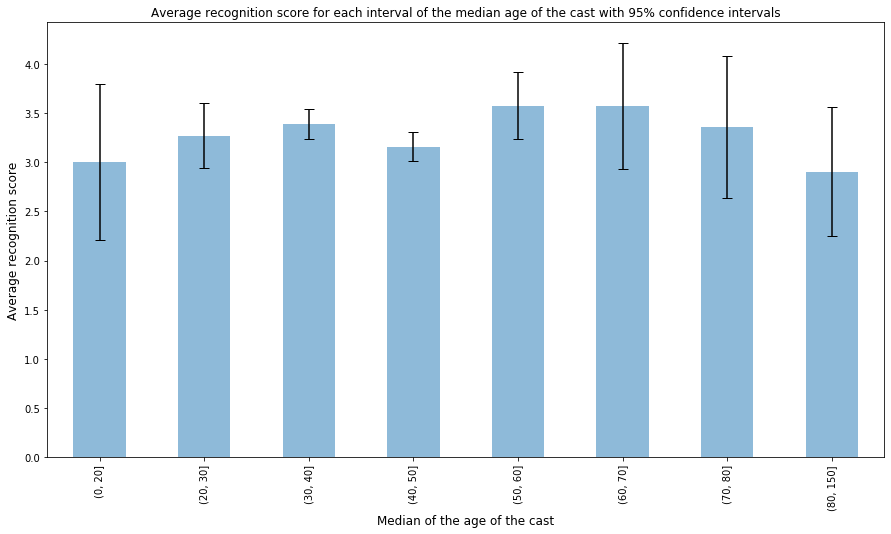

In [62]:
movies_stats_rec = movies_stats['recognition']
movies_stats_rec['errlo']  = movies_stats_rec['nanmean'] - movies_stats_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_rec['errhi']  = movies_stats_rec['95% CI mean'].apply(lambda x: x[1]) - movies_stats_rec['nanmean']

movies_stats_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median of the age of the cast", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of the median age of the cast with 95% confidence" +\
          " intervals" , size="large");

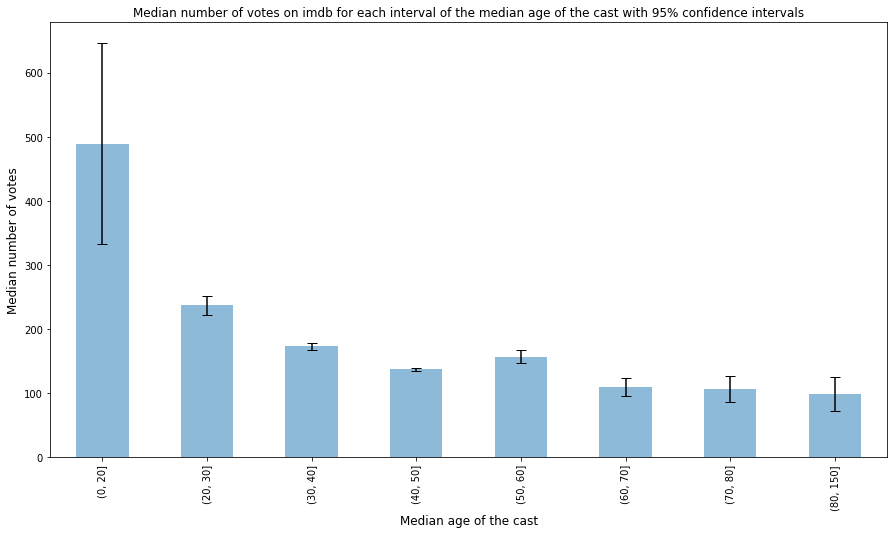

In [63]:
movies_stats_vot = movies_stats['numVotes']
movies_stats_vot['errlo']  = movies_stats_vot['nanmedian'] - movies_stats_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_vot['errhi']  = movies_stats_vot['95% CI median'].apply(lambda x: x[1]) - movies_stats_vot['nanmedian']

movies_stats_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes on imdb for each interval of the median age of the" \
          " cast with 95% confidence intervals", size="large");

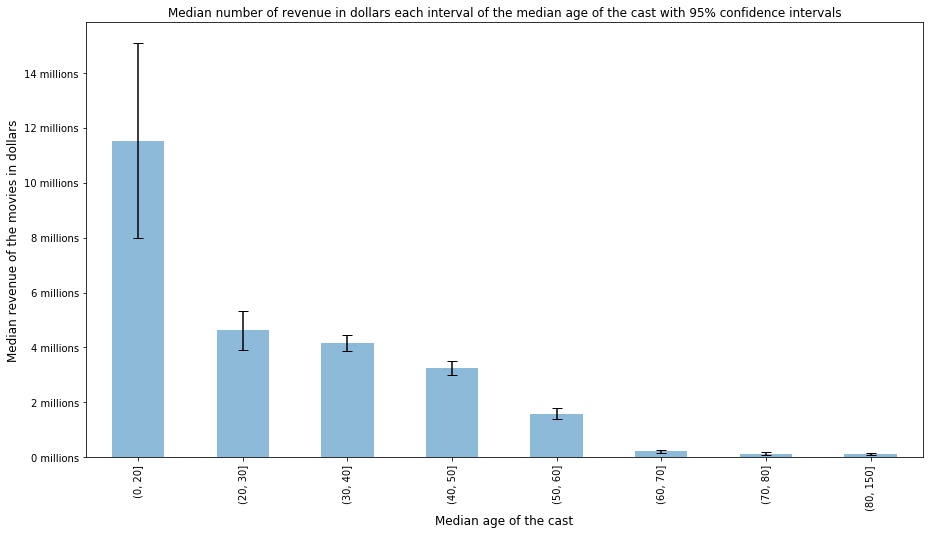

In [64]:
movies_stats_wor = movies_stats['worldwideGross_adjusted']
movies_stats_wor['errlo']  = movies_stats_wor['nanmedian'] - \
                             movies_stats_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_wor['errhi']  = movies_stats_wor['95% CI median'].apply(lambda x: x[1]) - \
                             movies_stats_wor['nanmedian']

g = movies_stats_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Median revenue of the movies in dollars", size="large")
plt.title("Median number of revenue in dollars for each interval of the median age of the cast with 95%" + \
          " confidence intervals", size="large");

ylabels = ['{:,.0f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

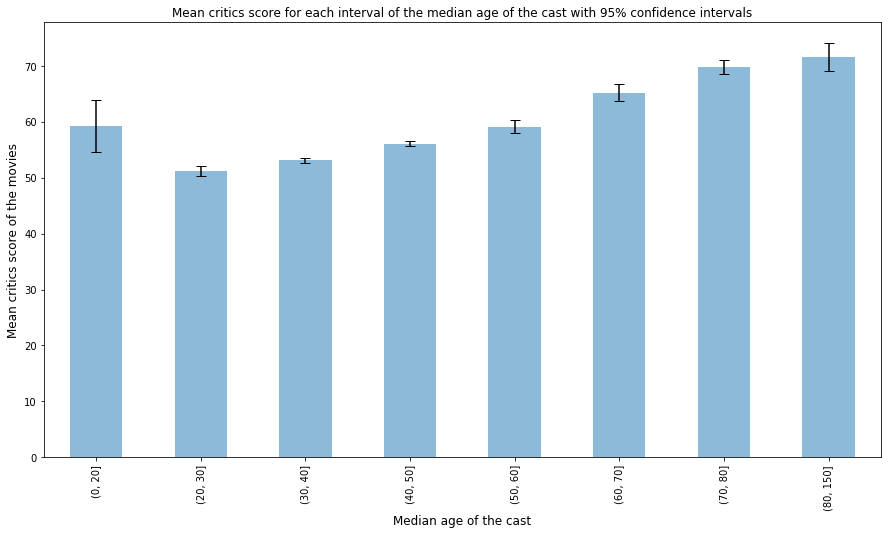

In [66]:
movies_stats_met = movies_stats['metascore']
movies_stats_met['errlo']  = movies_stats_met['nanmean'] - \
                             movies_stats_met['95% CI mean'].apply(lambda x: x[0])

movies_stats_met['errhi']  = movies_stats_met['95% CI mean'].apply(lambda x: x[1]) - \
                             movies_stats_met['nanmean']

movies_stats_met.plot(kind='bar', y='nanmean', yerr=movies_stats_met[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Mean critics score of the movies", size="large")
plt.title("Mean critics score for each interval of the median age of the cast with 95%" + \
          " confidence intervals", size="large");

# isAdult

In [68]:
recognized_movies.groupby('isAdult')['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanmedian])

recognition                       numVotes                         \
         cast_count   nanmean nanmedian cast_count      nanmean nanmedian   
isAdult                                                                     
0.0          506919  1.187113         0   231443.0  3319.715282      48.0   
1.0            8634  0.138290         0     4011.0    41.648217      15.0   

        worldwideGross_adjusted                            
                     cast_count       nanmean   nanmedian  
isAdult                                                    
0.0                     41268.0  2.217340e+07  520106.995  
1.0                         7.0  8.288359e+04   24874.760

In [69]:
recognized_movies.duplicated(subset=['tconst']).value_counts()

False    537913
dtype: int64

In [70]:
print('Total number of adults only movies: {0}'.format(len(recognized_movies[recognized_movies.isAdult == 1])))

Total number of adults only movies: 8634


### Awards based

#### Adult vs non-adult analysis of unsuccessful movies

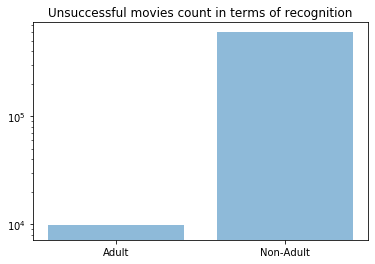

In [93]:
adult_count = len(unrecognized_movies[unrecognized_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(unrecognized_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Unsuccessful movies count in terms of recognition')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

#### Adult vs non-adult analysis of successful movies

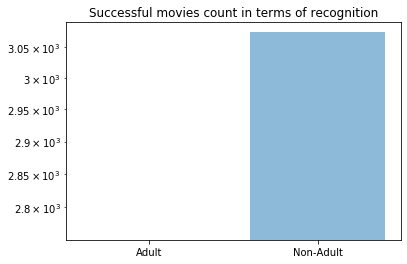

In [92]:
adult_count = len(top_recognized_movies[top_recognized_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_recognized_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Successful movies count in terms of recognition')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

In successful movies in terms of awards, we see that there are no adult labeled movies at all where as in the unsuccessful movies set, 1.6% are adult labeled. In general, none of the adults only movies have made it to the successful list.

### Popularity Based

#### Adult vs non-adult analysis of unsuccessful movies

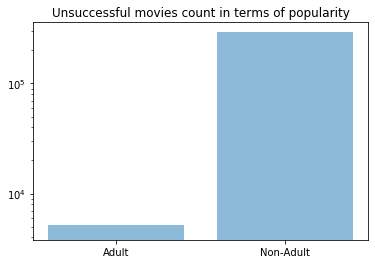

In [91]:
adult_count = len(unpopupar_movies[unpopupar_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(unpopupar_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Unsuccessful movies count in terms of popularity')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

#### Adult vs non-adult analysis of successful movies

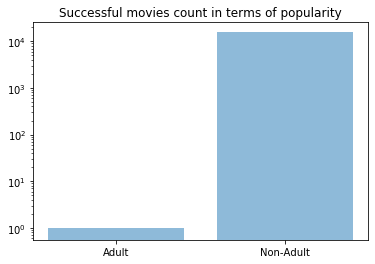

In [90]:
adult_count = len(top_popular_movies[top_popular_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_popular_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Successful movies count in terms of popularity')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

In successful movies in terms of popularity, we see that there is only 1 adult labeled movie where as in the unsuccessful movies set, 1.7% are adult labeled.

## Revenue Based

#### Adult vs non-adult analysis of unsuccessful movies

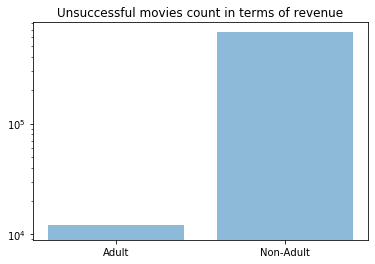

In [86]:
adult_count = len(loss_movies[loss_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(loss_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Unsuccessful movies count in terms of revenue')
plt.bar(labels, sizes, alpha=0.5)
plt.show()


#### Adult vs non-adult analysis of successful movies

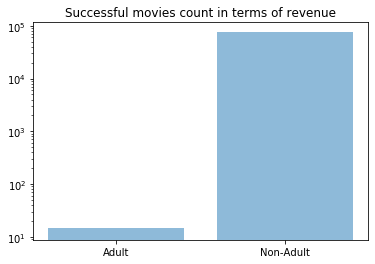

In [88]:
adult_count = len(top_profit_movies[top_profit_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_profit_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Successful movies count in terms of revenue')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

Once again, with the information considered, none of the Adult rated movies have made siginificant worldwide incomes.

## Metacritic score Based

#### Adult vs non-adult analysis of unsuccessful movies

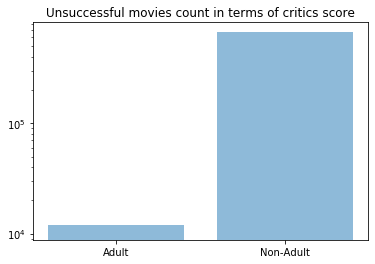

In [89]:
adult_count = len(low_meta_movies[low_meta_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(low_meta_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Unsuccessful movies count in terms of critics score')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

#### Adult vs non-adult analysis of successful movies

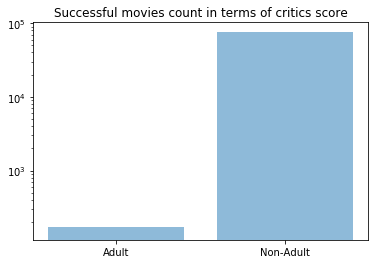

In [94]:
adult_count = len(top_meta_movies[top_meta_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_meta_movies) - adult_count]

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Successful movies count in terms of critics score')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

In conclusion, we see that adult rated movies seldom become very succesful in terms of awards, popularity, revenue and metacritic score.

# runtimeMinutes

In [104]:
length_success = recognized_movies[['tconst', 'primaryTitle', 'runtimeMinutes', 'recognition', \
                                    'numVotes', 'worldwideGross_adjusted', 'metascore']]

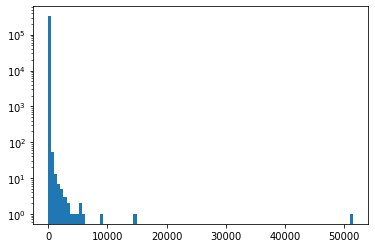

In [105]:
plt.hist(length_success['runtimeMinutes'], bins = 100);
plt.yscale('log', nonposy='clip')

In [106]:
length_success.nlargest(10, 'runtimeMinutes')[['tconst','primaryTitle', 'runtimeMinutes']]

,tconst,primaryTitle,runtimeMinutes
338139,tt8273150,Logistics,51420.0
412903,tt2659636,Modern Times Forever,14400.0
428351,tt2355497,Beijing 2003,9000.0
110065,tt5068890,Hunger!,6000.0
124657,tt5136218,London EC1,5460.0
178182,tt0284020,The Cure for Insomnia,5220.0
380124,tt5240738,Ember Glow,4980.0
484160,tt1735956,Deregulation,4200.0
330544,tt6150204,Nieuwe Tieten,4080.0
563849,tt1674154,City of Eternal Spring,3450.0


Even if the values are legit, we focus on the more conventional lengths

In [107]:
length_success = length_success[length_success['runtimeMinutes'] < 250]

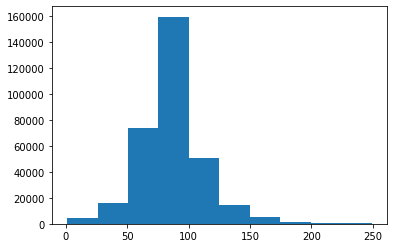

In [108]:
plt.hist(length_success['runtimeMinutes']);

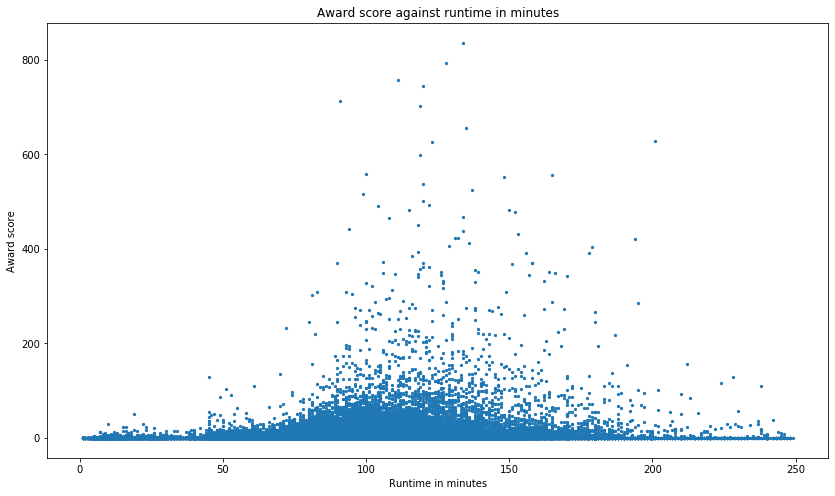

In [109]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['recognition'], s=5);

plt.title("Award score against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Award score');

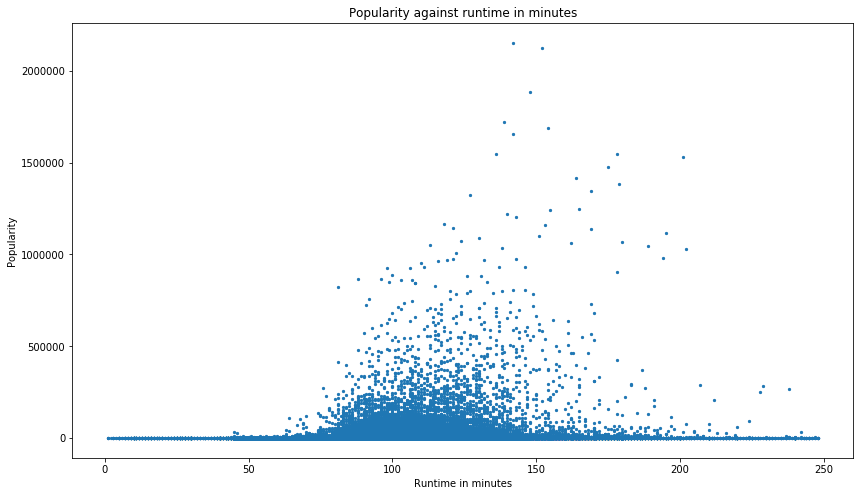

In [110]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['numVotes'], s=5);

plt.title("Popularity against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Popularity');

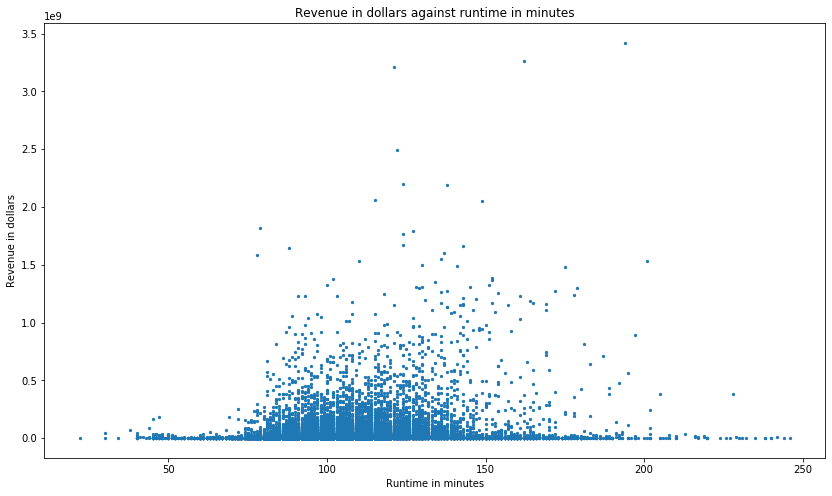

In [111]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Revenue in dollars');

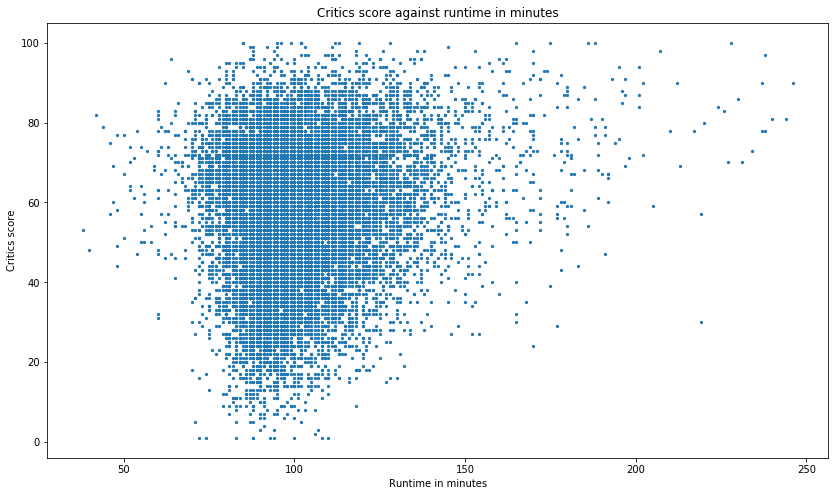

In [112]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['metascore'], s=5);

plt.title("Critics score against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Critics score');

Now we try to go more in-depth with more statistics for some runTime intervals

In [113]:
intervals = np.arange(50, 225, 25)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 250)
movies_stats_runtime = recognized_movies.groupby(pd.cut(recognized_movies['runtimeMinutes'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted', 'metascore']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_runtime = movies_stats_runtime.rename(columns={'<lambda_0>': '95% CI mean', \
'<lambda_1>': '95% CI median', '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [220]:
movies_stats_runtime['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",20280.0,0.170266,1.895009,0.0,130.0,0.0,"[0.15, 0.193]","[0.0, 0.0]",0.0,0.0,0.0,4.00
"(50, 75]",73912.0,0.298395,2.284970,0.0,232.0,0.0,"[0.285, 0.312]","[0.0, 0.0]",0.0,0.0,0.0,8.00
"(75, 100]",159546.0,1.414946,7.014593,0.0,713.0,0.0,"[1.387, 1.445]","[0.0, 0.0]",0.0,4.0,8.0,26.00
"(100, 125]",52152.0,4.173167,17.018593,0.0,757.0,0.0,"[4.053, 4.296]","[0.0, 0.0]",2.0,11.0,21.0,59.00
"(125, 150]",14089.0,5.621904,25.904823,0.0,836.0,0.0,"[5.298, 5.963]","[0.0, 0.0]",0.0,12.0,27.0,101.12
"(150, 175]",4617.0,5.549924,27.053756,0.0,556.0,0.0,"[4.923, 6.25]","[0.0, 0.0]",0.0,10.0,23.0,108.68
"(175, 200]",1246.0,6.403692,29.028084,0.0,420.0,0.0,"[5.067, 7.828]","[0.0, 0.0]",0.0,14.0,31.0,110.55
"(200, 250]",610.0,4.380328,28.994472,0.0,628.0,0.0,"[2.767, 6.635]","[0.0, 0.0]",0.0,6.0,20.0,92.28


In [221]:
movies_stats_runtime['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",3920.0,90.698469,823.260352,5.0,34937.0,14.0,"[70.728, 115.458]","[13.0, 14.0]",31.00,92.0,207.05,1209.54
"(50, 75]",31988.0,192.273884,2159.279361,5.0,134792.0,22.0,"[172.908, 213.102]","[22.0, 22.0]",67.00,215.0,474.65,2237.39
"(75, 100]",115276.0,1879.597375,15873.808312,5.0,928857.0,63.0,"[1805.873, 1958.482]","[63.0, 64.0]",298.00,1383.0,3934.25,39119.25
"(100, 125]",40947.0,7930.868073,43533.524295,5.0,1166368.0,155.0,"[7591.897, 8291.386]","[150.0, 159.0]",997.00,7403.0,28666.60,190630.92
"(125, 150]",10501.0,14700.539377,80964.766919,5.0,2153889.0,137.0,"[13391.417, 15991.906]","[130.0, 144.0]",1079.00,9820.0,51133.00,389557.00
"(150, 175]",3680.0,12722.025000,91373.860960,5.0,2126738.0,158.0,"[10381.556, 15161.862]","[142.0, 172.0]",1064.50,6375.7,19450.15,373261.91
"(175, 200]",884.0,15283.737557,107698.782564,5.0,1545029.0,108.5,"[10011.797, 21770.402]","[86.0, 135.0]",1014.00,8417.2,29797.45,309899.02
"(200, 250]",412.0,11301.138350,95171.036257,5.0,1529752.0,60.5,"[4503.006, 20306.955]","[54.0, 71.0]",311.75,3383.0,11366.35,266836.94


In [222]:
movies_stats_runtime['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",90.0,1.253490e+07,2.851897e+07,615.48,1.791959e+08,815067.195,"[8219647.834, 17510771.909]","[199187.34, 2628970.51]",1.289249e+07,3.216187e+07,3.971087e+07,1.628237e+08
"(50, 75]",1206.0,2.487612e+06,1.385147e+07,15.69,2.543084e+08,34340.020,"[1894947.326, 3151090.19]","[28337.02, 41941.325]",4.932815e+05,3.405241e+06,7.326030e+06,5.536797e+07
"(75, 100]",19395.0,1.284442e+07,6.106506e+07,13.77,1.814742e+09,326685.000,"[12135847.368, 13550506.074]","[311160.984, 340345.865]",2.770202e+06,1.999040e+07,5.584538e+07,2.596863e+08
"(100, 125]",12842.0,3.071163e+07,1.027389e+08,0.00,3.213030e+09,1780464.550,"[29190408.281, 32099980.605]","[1698512.338, 1875967.763]",1.397058e+07,7.407834e+07,1.624319e+08,4.787187e+08
"(125, 150]",2921.0,6.814380e+07,1.931978e+08,30.72,2.191172e+09,2812867.430,"[62407297.139, 74183537.29]","[2342264.0, 3342807.705]",3.089665e+07,1.838856e+08,3.917499e+08,1.036380e+09
"(150, 175]",742.0,6.418009e+07,2.347458e+08,43.03,3.265544e+09,794014.895,"[50975139.608, 78303614.139]","[622967.629, 1089805.79]",9.057995e+06,1.243332e+08,3.713177e+08,1.209124e+09
"(175, 200]",168.0,7.937941e+07,3.243974e+08,1494.28,3.421994e+09,1445004.895,"[43481241.774, 125418215.146]","[922512.02, 2160680.531]",1.010671e+07,1.192600e+08,4.592539e+08,1.256336e+09
"(200, 250]",48.0,5.866186e+07,2.321675e+08,305.76,1.529402e+09,801749.560,"[14479790.526, 120222894.822]","[174273.97, 1725796.87]",1.127056e+07,4.962165e+07,3.322342e+08,9.891371e+08


In [115]:
movies_stats_runtime['metascore']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",15.0,63.066667,12.819999,44.0,82.0,60.0,"[57.8, 68.43]","[53.0, 75.0]",76.00,78.2,79.90,81.58
"(50, 75]",405.0,62.427160,15.033387,1.0,96.0,65.0,"[61.141, 63.636]","[63.0, 66.0]",72.00,79.0,82.80,90.96
"(75, 100]",7731.0,55.128444,17.898374,1.0,100.0,57.0,"[54.776, 55.469]","[56.0, 57.0]",69.00,77.0,82.00,90.00
"(100, 125]",5497.0,58.062216,16.807145,1.0,100.0,59.0,"[57.685, 58.406]","[58.0, 59.0]",71.00,80.0,85.00,92.00
"(125, 150]",1143.0,64.548556,15.234163,15.0,100.0,65.0,"[63.763, 65.219]","[64.0, 66.0]",76.00,84.0,88.00,94.58
"(150, 175]",202.0,69.351485,16.519255,24.0,100.0,71.5,"[67.456, 71.215]","[68.0, 74.0]",81.75,90.0,93.00,98.00
"(175, 200]",72.0,71.916667,14.328883,29.0,100.0,72.0,"[69.257, 74.643]","[69.0, 75.0]",84.00,89.0,91.45,100.00
"(200, 250]",29.0,79.586207,14.208944,30.0,100.0,81.0,"[74.86, 83.603]","[78.0, 85.0]",90.00,94.6,97.60,99.44


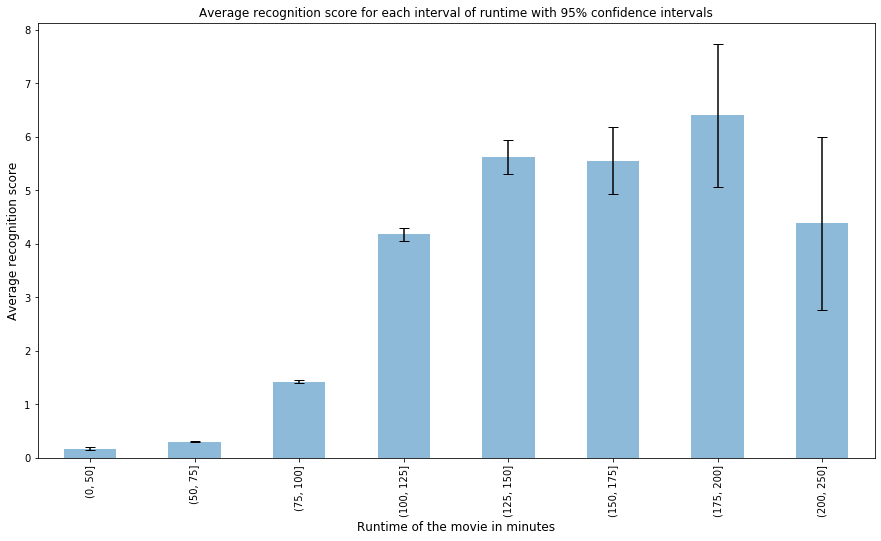

In [223]:
movies_stats_run_rec = movies_stats_runtime['recognition']
movies_stats_run_rec['errlo']  = movies_stats_run_rec['nanmean'] - \
                                 movies_stats_run_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_run_rec['errhi']  = movies_stats_run_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_run_rec['nanmean']

movies_stats_run_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_run_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

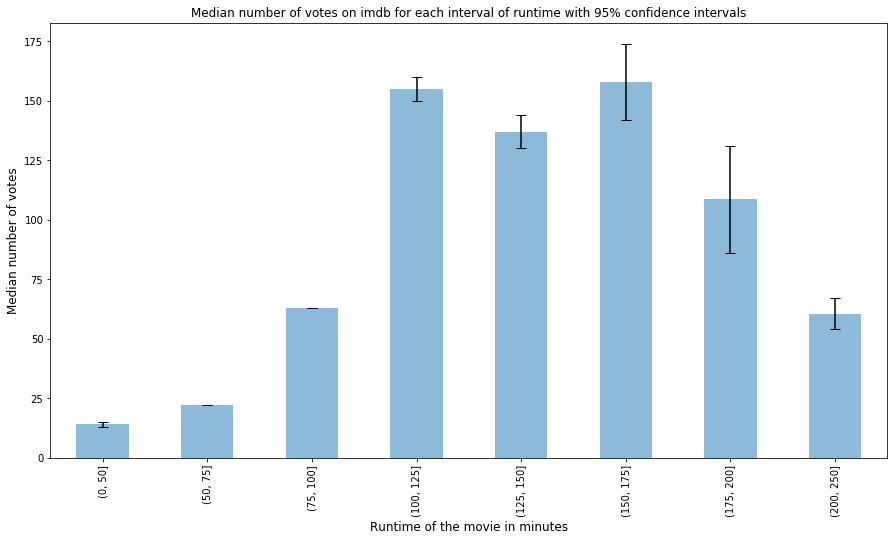

In [224]:
movies_stats_run_vot = movies_stats_runtime['numVotes']
movies_stats_run_vot['errlo']  = movies_stats_run_vot['nanmedian'] - \
                                 movies_stats_run_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_run_vot['errhi']  = movies_stats_run_vot['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_run_vot['nanmedian']

movies_stats_run_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_run_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes on imdb for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

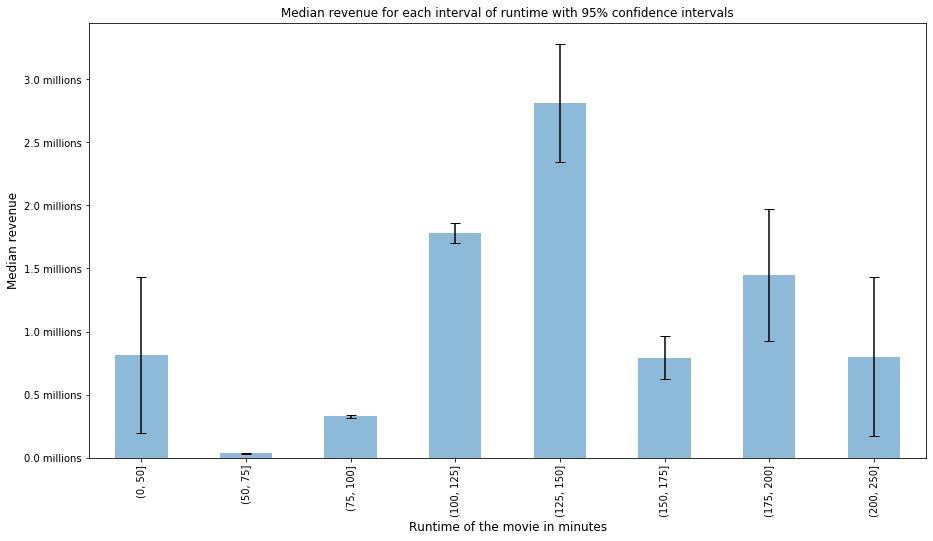

In [225]:
movies_stats_run_wor = movies_stats_runtime['worldwideGross_adjusted']
movies_stats_run_wor['errlo']  = movies_stats_run_wor['nanmedian'] - \
                                 movies_stats_run_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_run_wor['errhi']  = movies_stats_run_wor['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_run_wor['nanmedian']

g = movies_stats_run_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_run_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");
ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

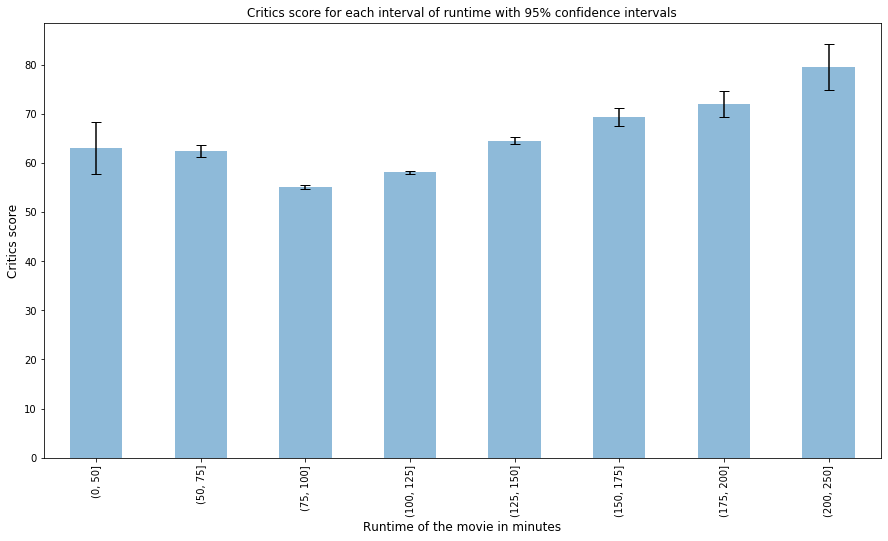

In [117]:
movies_stats_run_met = movies_stats_runtime['metascore']
movies_stats_run_met['errlo']  = movies_stats_run_met['nanmean'] - \
                                 movies_stats_run_met['95% CI mean'].apply(lambda x: x[0])

movies_stats_run_met['errhi']  = movies_stats_run_met['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_run_met['nanmean']

movies_stats_run_met.plot(kind='bar', y='nanmean', yerr=movies_stats_run_met[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Critics score", size="large")
plt.title("Critics score for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

# plotKeywords

Instead of doing statistics for each keywords, we get the top 1000 of movies in term of recognition, number of votes and revenue and compare the keywords of those movies with the other ones.

Because of the explicit nature of the adult movies plot keywords, we only take into account the family-friendly movies in this section.

In [136]:
top_n = 10000

In [120]:
#We take the first top_n with respect to each metric
recognized_movies_christian = recognized_movies[recognized_movies['isAdult'] == 0.0]
top_recognition = recognized_movies_christian.sort_values('recognition', ascending=False).head(top_n)
top_numVotes = recognized_movies_christian.sort_values('numVotes', ascending=False).head(top_n)
top_revenue = recognized_movies_christian.sort_values('worldwideGross_adjusted', ascending=False).head(top_n)
top_metascore = recognized_movies_christian.sort_values('metascore', ascending=False).head(top_n)

In [121]:
#We just take the oscarWins because we only want one column, it has nothing to do with the oscarWins
#We count the occurences of plot keywords
top_reco_keywords = top_recognition.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_numV_keywords = top_numVotes.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_rev_keywords = top_revenue.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_met_keywords = top_metascore.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']

In [122]:
#We only keep the top 20 keywords 
top_reco_keywords = top_reco_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_reco_keywords['top_rank'] = top_reco_keywords['cast_count'].rank(ascending=False, method='dense')
top_reco_keywords = top_reco_keywords.reset_index()

In [123]:
top_numV_keywords = top_numV_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_numV_keywords['top_rank'] = top_numV_keywords['cast_count'].rank(ascending=False, method='dense')
top_numV_keywords = top_numV_keywords.reset_index()

In [124]:
top_rev_keywords = top_rev_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_rev_keywords['top_rank'] = top_rev_keywords['cast_count'].rank(ascending=False, method='dense')
top_rev_keywords = top_rev_keywords.reset_index()

In [125]:
top_met_keywords = top_met_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_met_keywords['top_rank'] = top_met_keywords['cast_count'].rank(ascending=False, method='dense')
top_met_keywords = top_met_keywords.reset_index()

In [126]:
#We do the same thing but with every movies that is not in the top in order to compute the difference of rank
bad_recognition = recognized_movies_christian.sort_values('recognition', ascending=True)\
                 .head(len(recognized_movies)-top_n)

bad_numVotes = recognized_movies_christian.sort_values('numVotes', ascending=True)\
              .head(len(recognized_movies)-top_n)

bad_revenue = recognized_movies_christian.sort_values('worldwideGross_adjusted', ascending=True)\
             .head(len(recognized_movies)-top_n)

bad_metascore = recognized_movies_christian.sort_values('metascore', ascending=True)\
             .head(len(recognized_movies)-top_n)

In [127]:
#We just take the oscarWins because we only want one column, it has nothing to do with the oscarWins
bad_reco_keywords = bad_recognition.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
bad_numV_keywords = bad_numVotes.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
bad_rev_keywords = bad_revenue.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
bad_met_keywords = bad_metascore.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']

In [128]:
bad_reco_keywords['bad_rank'] = bad_reco_keywords['cast_count'].rank(ascending=False, method='dense')
bad_reco_keywords = bad_reco_keywords.reset_index()

In [129]:
bad_numV_keywords['bad_rank'] = bad_numV_keywords['cast_count'].rank(ascending=False, method='dense')
bad_numV_keywords = bad_numV_keywords.reset_index()

In [130]:
bad_rev_keywords['bad_rank'] = bad_rev_keywords['cast_count'].rank(ascending=False, method='dense')
bad_rev_keywords = bad_rev_keywords.reset_index()

In [131]:
bad_met_keywords['bad_rank'] = bad_rev_keywords['cast_count'].rank(ascending=False, method='dense')
bad_met_keywords = bad_rev_keywords.reset_index()

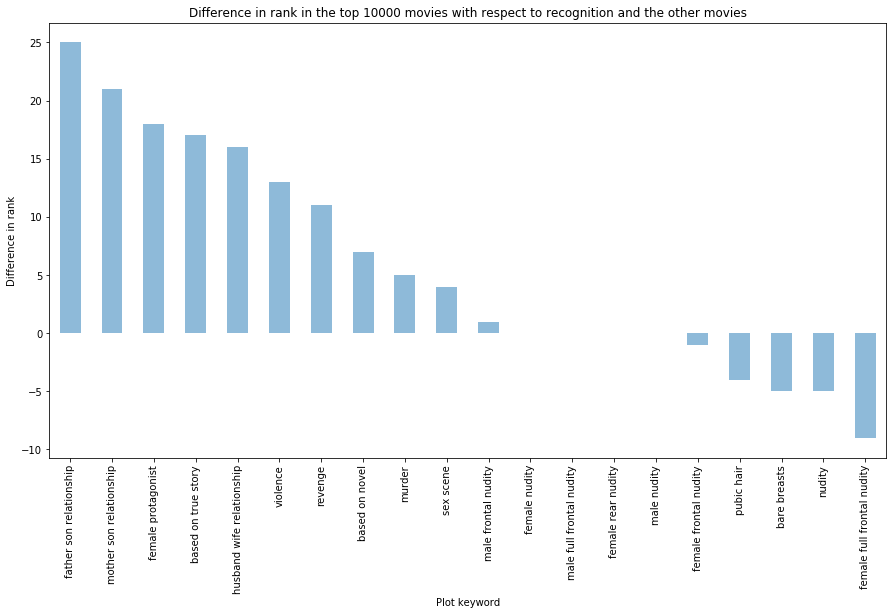

In [132]:
reco_keywords = top_reco_keywords.merge(bad_reco_keywords, how='inner', on='plotKeywords')
reco_keywords['diff'] = reco_keywords['bad_rank'] - reco_keywords['top_rank']
reco_keywords = reco_keywords.sort_values('diff', ascending=False)
reco_keywords = reco_keywords.set_index('plotKeywords')
reco_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to recognition and the other movies'.format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');

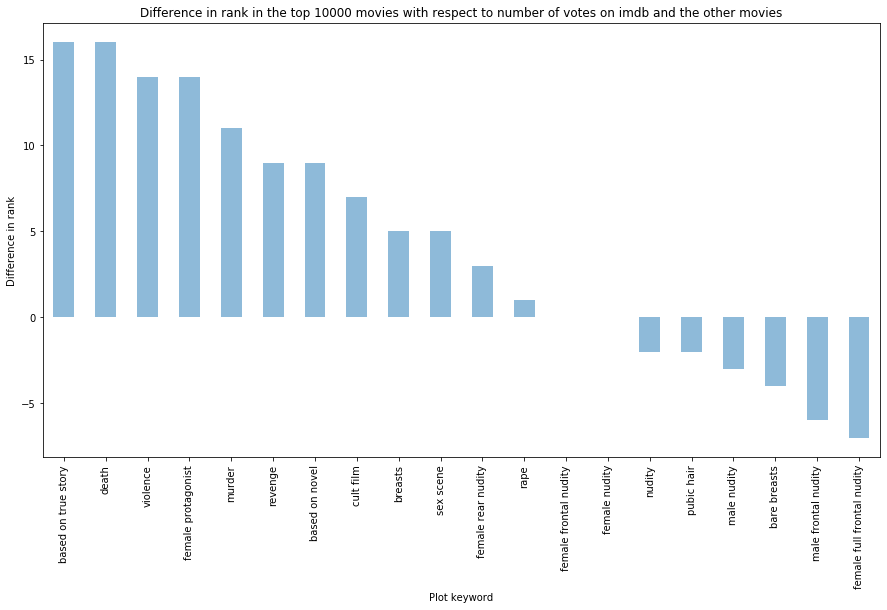

In [133]:
numV_keywords = top_numV_keywords.merge(bad_numV_keywords, how='inner', on='plotKeywords')
numV_keywords['diff'] = numV_keywords['bad_rank'] - numV_keywords['top_rank']
numV_keywords = numV_keywords.sort_values('diff', ascending=False)
numV_keywords = numV_keywords.set_index('plotKeywords')
numV_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to number of votes on imdb and the other movies'\
          .format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');

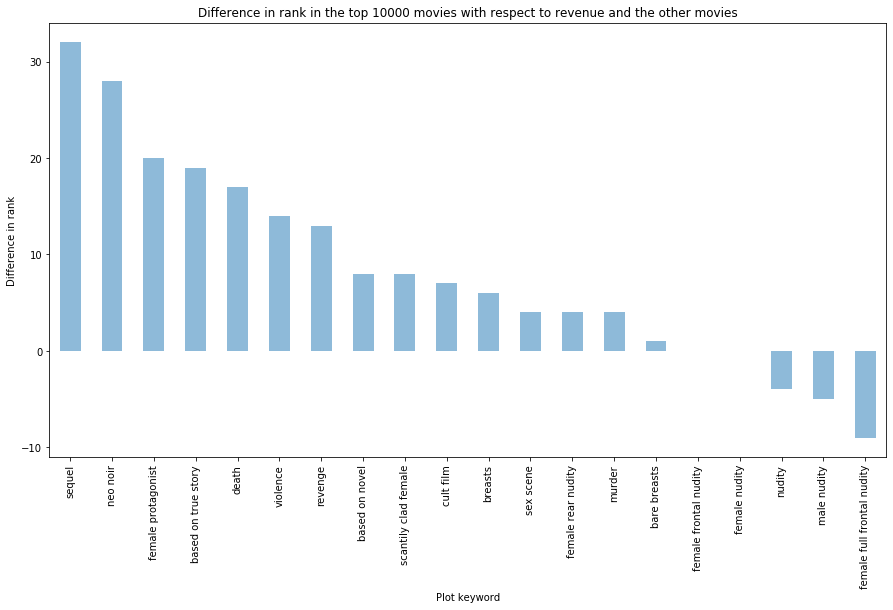

In [134]:
rev_keywords = top_rev_keywords.merge(bad_rev_keywords, how='inner', on='plotKeywords')
rev_keywords['diff'] = rev_keywords['bad_rank'] - rev_keywords['top_rank']
rev_keywords = rev_keywords.sort_values('diff', ascending=False)
rev_keywords = rev_keywords.set_index('plotKeywords')
rev_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to revenue and the other movies'.format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');

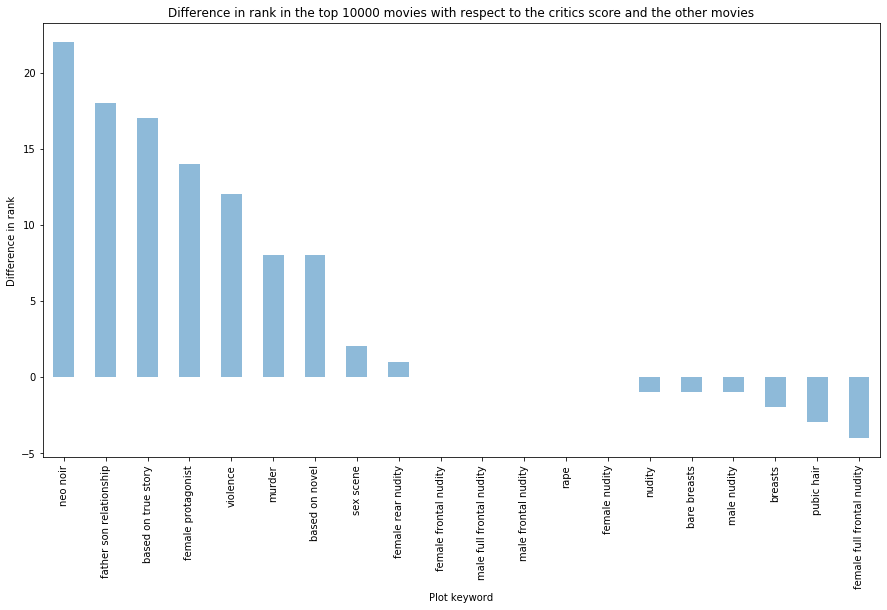

In [135]:
met_keywords = top_met_keywords.merge(bad_met_keywords, how='inner', on='plotKeywords')
met_keywords['diff'] = met_keywords['bad_rank'] - met_keywords['top_rank']
met_keywords = met_keywords.sort_values('diff', ascending=False)
met_keywords = met_keywords.set_index('plotKeywords')
met_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to the critics score and the other movies'\
          .format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');


# Genres

In [137]:
movies_filtered = pd.read_pickle('pickles/filtered_movies.pkl')
movies_genres = movies_filtered[['tconst', 'genres']]
recognized_movies = recognized_movies.drop(['genres'], axis=1)
recognized_movies = recognized_movies.merge(movies_genres, on='tconst', how='left')
recognized_movies = recognized_movies.replace('\\N', np.nan)
recognized_movies['genres'] = recognized_movies['genres'].apply(split_str_list)
recognized_movies

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,cast,count,averageRating,numVotes,recognition,worldwideGross_adjusted,age_median,cast_count,credible_median,genres
0,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,"[nm0252230, nm4833412, nm6003176, nm0061262, n...",97.0,8.1,590369.0,836,2.023595e+08,42.5,32.0,42.5,"[Biography, Drama, History]"
1,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,"[nm0331516, nm1297015, nm2353430, nm0881814, n...",221.0,8.0,451658.0,794,4.667229e+08,36.5,54.0,36.5,"[Comedy, Drama, Music]"
2,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,"[nm0991810, nm8401402, nm5429086, nm7683379, n...",27.0,7.4,237473.0,757,6.805492e+07,37.0,5.0,NaN,[Drama]
3,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,"[nm0362766, nm0000234, nm0396558, nm0117412, n...",80.0,8.1,802392.0,744,3.975142e+08,40.0,25.0,40.0,"[Action, Adventure, Sci-Fi]"
4,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,"[nm0000113, nm0000123, nm0000438, nm1241511, n...",8.0,7.7,724190.0,713,7.795368e+08,53.0,4.0,NaN,"[Drama, Sci-Fi, Thriller]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537908,tt0073224,"[nm0451211, nm0044916, nm0159159]",0,0,0,1975-07-29,India,[],None,None,...,"[nm0451211, nm0044916, nm0159159, nm0416077, n...",30.0,6.5,46.0,0,NaN,38.5,16.0,38.5,"[Action, Thriller]"
537909,tt0073212,"[nm0181008, nm0094746, nm0297212]",0,0,0,1975-04-25,Sweden,[],None,None,...,"[nm0181008, nm0094746, nm0297212, nm0116066, n...",29.0,4.7,104.0,0,NaN,42.0,21.0,42.0,[Comedy]
537910,tt0073135,"[nm0653157, nm0575416, nm0035276]",0,0,0,1975-09-04,Norway,[],None,None,...,"[nm0653157, nm0575416, nm0035276, nm0021792, n...",11.0,5.5,203.0,0,NaN,37.5,10.0,NaN,"[Comedy, Drama]"
537911,tt0073210,"[nm0595991, nm0576127, nm0133597]",0,0,0,NaT,USA,[],"$200,000",None,...,"[nm0595991, nm0576127, nm0133597, nm0215308, n...",18.0,6.4,287.0,0,NaN,42.0,11.0,42.0,"[Crime, Drama, Thriller]"


In [138]:
genres = recognized_movies.explode('genres').groupby('genres')['tconst']\
         .agg({'size': len, 'set': lambda x: set(x)})

We remove the small set such as Game-show, Short and Talk-show

In [139]:
genres = genres[genres['size'] > 100].reset_index()

In [140]:
jaccard = df_crossjoin(genres)

In [141]:
jaccard['distance'] = np.vectorize(jaccard_similarity)(jaccard['set_x'], jaccard['set_y'])
jaccard = jaccard.drop(['set_x', 'set_y'], axis=1)

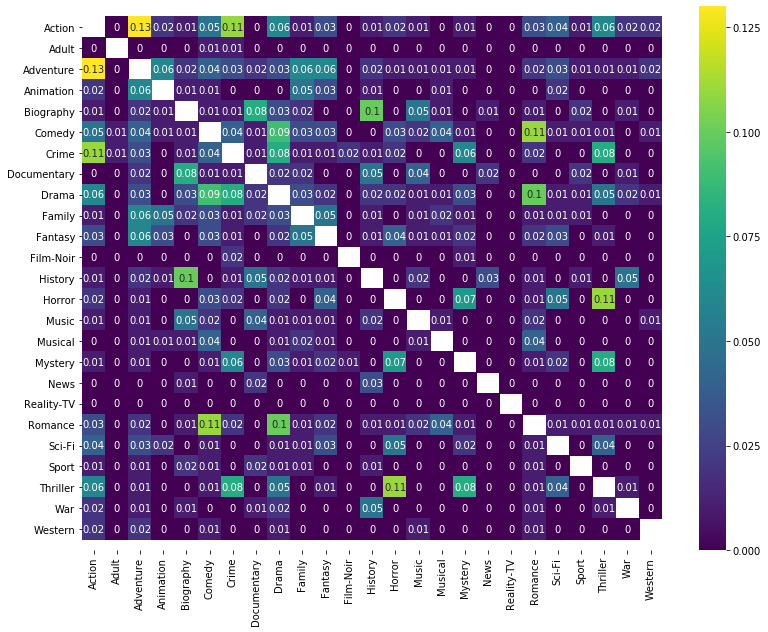

In [142]:
jaccard_pivot = jaccard.pivot(index='genres_x', columns='genres_y', values='distance')
plt.figure(figsize=(13,10))

mask = np.zeros((len(jaccard_pivot), len(jaccard_pivot)))
mask[np.diag_indices(len(jaccard_pivot))] = True

ax = sns.heatmap(jaccard_pivot, mask=mask, fmt="g", cmap='viridis', vmax = 0.13, annot=True)
ax.set_ylim(len(jaccard_pivot)+0.5, -0.5);
ax.set_xlabel('');
ax.set_ylabel('');

In [198]:
genres_success = recognized_movies.explode('genres').groupby('genres')['recognition', 'numVotes',\
                                                                       'worldwideGross_adjusted',\
                                                                       'metascore']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

genres_success = genres_success.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [199]:
genres_success['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,45390,1.370302,10.504696,0,744,0,"[1.286, 1.454]","[0.0, 0.0]",0,0,6.0,31.00
Adult,7852,0.138436,1.248743,0,29,0,"[0.116, 0.162]","[0.0, 0.0]",0,0,0.0,5.00
Adventure,24357,2.235127,16.497167,0,744,0,"[2.076, 2.425]","[0.0, 0.0]",0,2,8.0,50.44
Animation,6790,2.308100,13.421575,0,305,0,"[2.043, 2.572]","[0.0, 0.0]",0,3,10.0,56.00
Biography,15225,3.425878,19.509394,0,836,0,"[3.177, 3.682]","[0.0, 0.0]",0,6,15.0,71.00
Comedy,92358,1.471286,9.069945,0,794,0,"[1.423, 1.522]","[0.0, 0.0]",0,3,8.0,28.00
Crime,30670,2.137789,12.525441,0,517,0,"[2.024, 2.265]","[0.0, 0.0]",0,4,11.0,40.00
Documentary,100293,0.560378,3.362873,0,159,0,"[0.543, 0.579]","[0.0, 0.0]",0,0,4.0,13.00
Drama,189541,2.303254,12.881923,0,836,0,"[2.255, 2.354]","[0.0, 0.0]",0,5,12.0,39.00


In [200]:
genres_success['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,25873.0,9245.040467,56842.256875,5.0,2126738.0,89.0,"[8680.283, 9830.78]","[86.0, 92.0]",640.00,5138.8,26020.60,238643.52
Adult,3771.0,48.564041,539.103624,5.0,31787.0,15.0,"[37.547, 64.873]","[14.0, 15.0]",33.00,68.0,120.00,400.20
Adventure,16048.0,12516.732490,71004.357864,5.0,1887822.0,73.0,"[11554.954, 13444.667]","[70.0, 76.0]",590.25,6067.5,45708.60,340891.65
Animation,3927.0,11238.931500,56926.185878,5.0,928857.0,122.0,"[9884.419, 12818.033]","[113.0, 133.0]",907.00,9182.4,47694.10,250091.00
Biography,7106.0,7048.644948,43880.102039,5.0,1117135.0,74.0,"[6209.174, 7959.241]","[69.0, 79.0]",718.00,6037.5,25119.00,151042.05
Comedy,61004.0,3779.423923,25664.389380,5.0,978083.0,85.0,"[3613.355, 3958.796]","[83.0, 87.0]",463.00,2788.1,9883.25,88148.66
Crime,20534.0,6897.134752,46308.837943,5.0,2126738.0,118.0,"[6374.673, 7463.274]","[114.0, 122.525]",827.75,6387.1,22664.40,144269.25
Documentary,33232.0,284.136074,2297.236545,5.0,135933.0,21.0,"[264.283, 304.958]","[20.0, 21.0]",70.00,287.0,743.45,5001.73
Drama,106411.0,3620.775888,32922.880593,5.0,2153889.0,65.0,"[3456.529, 3775.714]","[64.0, 66.0]",357.00,2232.0,7531.00,76127.80


In [201]:
genres_success['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,5167.0,6.765785e+07,1.903379e+08,33.24,3.265544e+09,3976431.200,"[63032047.653, 72102486.278]","[3559758.79, 4479055.98]",3.729202e+07,1.871935e+08,3.790258e+08,9.190059e+08
Adult,4.0,4.045987e+04,5.305557e+04,1266.54,1.186690e+05,20951.970,"[nan, nan]","[nan, nan]",4.832332e+04,9.053074e+04,1.045999e+05,1.158552e+05
Adventure,3260.0,1.122755e+08,2.641119e+08,118.66,3.265544e+09,8094606.805,"[104315422.465, 120155693.186]","[7027826.53, 8993676.866]",7.623045e+07,3.538049e+08,6.758721e+08,1.232232e+09
Animation,1729.0,6.308510e+07,1.848597e+08,127.28,1.814742e+09,3049788.660,"[55783550.739, 70481605.588]","[2621908.926, 3453748.978]",2.039796e+07,1.625414e+08,4.071139e+08,9.472633e+08
Biography,2043.0,2.029369e+07,6.907537e+07,35.12,1.270452e+09,845315.160,"[18116793.234, 22983041.408]","[724896.432, 973800.1]",7.418578e+06,4.611808e+07,1.073065e+08,3.407561e+08
Comedy,14129.0,2.483723e+07,8.495615e+07,15.69,1.814742e+09,1342740.410,"[23674821.1, 26043254.488]","[1266241.42, 1415540.31]",9.614211e+06,5.322056e+07,1.282884e+08,4.203703e+08
Crime,4337.0,2.732538e+07,7.657889e+07,37.37,1.477943e+09,1950390.490,"[25490946.275, 29235911.686]","[1765996.395, 2177678.0]",1.826803e+07,7.364903e+07,1.483529e+08,3.629773e+08
Documentary,4399.0,1.417132e+06,1.074489e+07,35.12,3.057048e+08,42163.870,"[1166247.727, 1705779.51]","[39722.11, 45357.696]",2.203955e+05,1.164545e+06,3.250423e+06,2.714542e+07
Drama,20784.0,1.702852e+07,7.620578e+07,0.00,3.421994e+09,542376.760,"[16165124.027, 17957865.797]","[513598.785, 567006.92]",4.878285e+06,3.209719e+07,8.085646e+07,3.129557e+08


In [202]:
genres_success['metascore']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
genres,,,,,,,,,,,,
Action,2063.0,49.639360,16.879439,3.0,98.0,49.0,"[49.056, 50.252]","[49.0, 50.0]",62.00,72.0,77.9,87.00
Adult,1.0,41.000000,NaN,41.0,41.0,41.0,"[nan, nan]","[nan, nan]",41.00,41.0,41.0,41.00
Adventure,1548.0,54.847545,17.784315,1.0,100.0,55.0,"[54.079, 55.564]","[54.0, 56.0]",67.00,78.3,85.0,93.00
Animation,482.0,61.958506,17.461759,12.0,99.0,64.0,"[60.736, 63.303]","[61.0, 65.0]",74.75,83.0,88.0,95.19
Biography,1303.0,64.367613,14.238772,2.0,100.0,66.0,"[63.752, 65.029]","[65.0, 67.0]",74.50,81.0,86.0,91.00
Comedy,4788.0,52.889515,17.355850,1.0,99.0,53.0,"[52.483, 53.304]","[53.0, 54.0]",66.00,75.0,81.0,90.00
Crime,2138.0,55.675398,18.007209,5.0,100.0,57.0,"[55.019, 56.315]","[56.0, 57.0]",69.00,78.0,84.0,91.63
Documentary,2622.0,66.900076,12.344412,1.0,100.0,68.0,"[66.509, 67.3]","[68.0, 69.0]",75.00,81.0,85.0,90.79
Drama,8566.0,59.390030,16.840268,1.0,100.0,61.0,"[59.09, 59.692]","[60.0, 61.0]",72.00,81.0,85.0,93.00


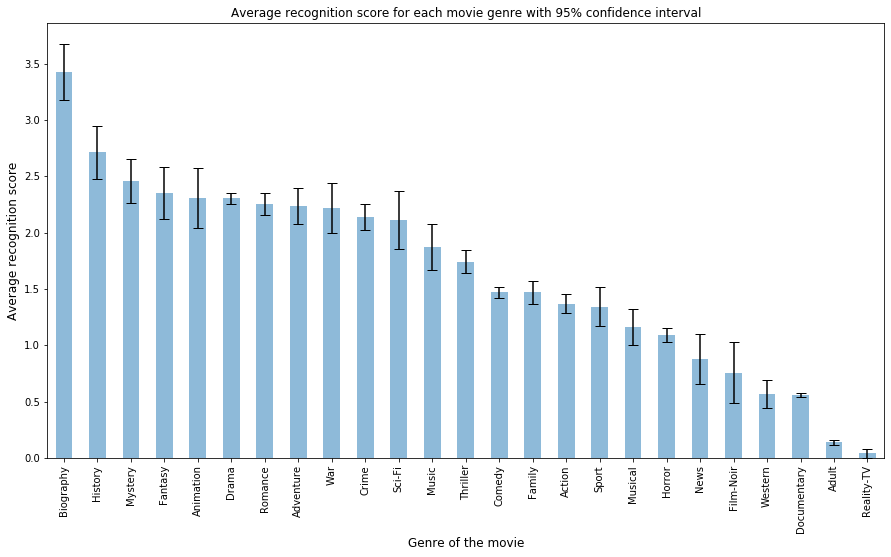

In [203]:
movies_stats_gen_rec = genres_success[genres_success['recognition']['cast_count'] > 100]['recognition']
movies_stats_gen_rec['errlo']  = movies_stats_gen_rec['nanmean'] - \
                                 movies_stats_gen_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_gen_rec['errhi']  = movies_stats_gen_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_rec['nanmean']

movies_stats_gen_rec = movies_stats_gen_rec.sort_values('nanmean', ascending=False)

movies_stats_gen_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_gen_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each movie genre with 95% confidence interval" , size="large");

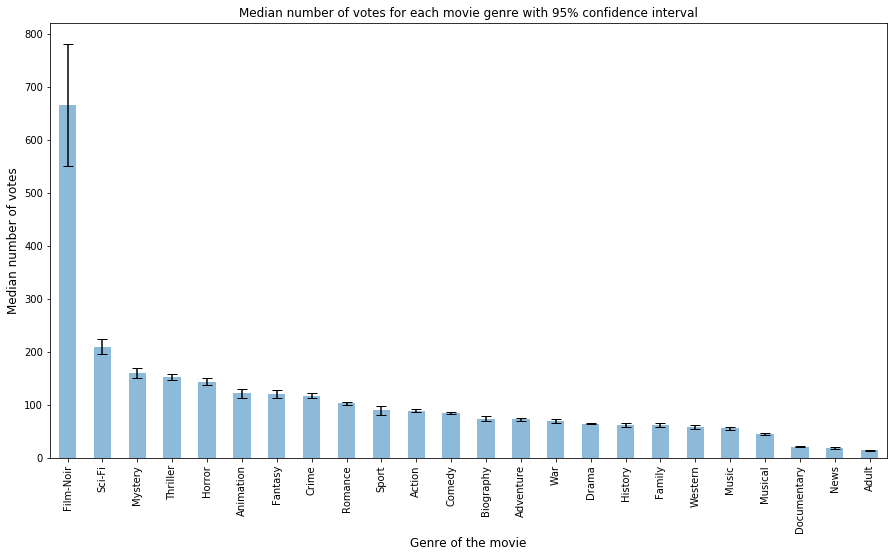

In [204]:
movies_stats_gen_vot = genres_success[genres_success['numVotes']['cast_count'] > 100]['numVotes']

movies_stats_gen_vot['errlo']  = movies_stats_gen_vot['nanmedian'] - \
                                 movies_stats_gen_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_gen_vot['errhi']  = movies_stats_gen_vot['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_vot['nanmedian']

movies_stats_gen_vot = movies_stats_gen_vot.sort_values('nanmedian', ascending=False)

movies_stats_gen_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_gen_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes for each movie genre with 95% confidence interval" , size="large");

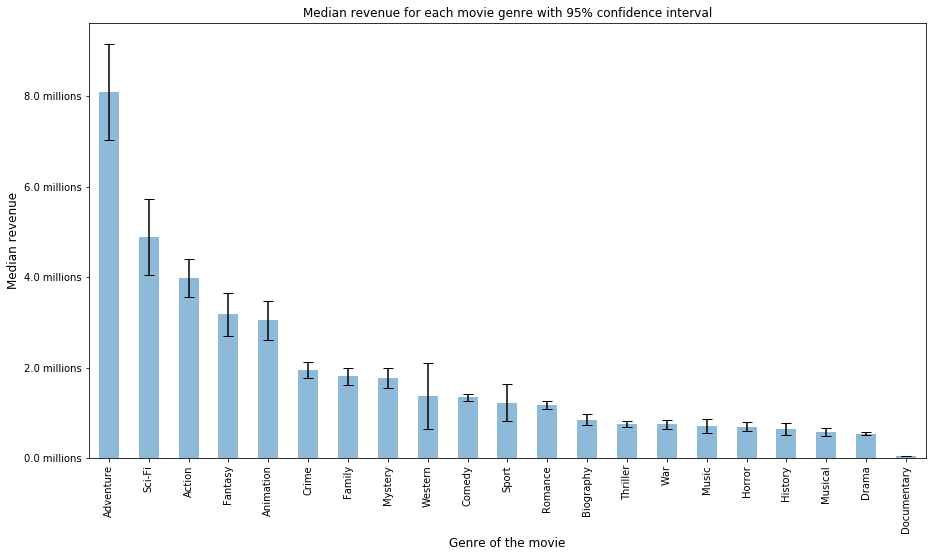

In [205]:
movies_stats_gen_wor = genres_success[genres_success['worldwideGross_adjusted']['cast_count'] > 100]\
                                                    ['worldwideGross_adjusted']

movies_stats_gen_wor['errlo']  = movies_stats_gen_wor['nanmedian'] - \
                                 movies_stats_gen_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_gen_wor['errhi']  = movies_stats_gen_wor['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_wor['nanmedian']

movies_stats_gen_wor = movies_stats_gen_wor.sort_values('nanmedian', ascending=False)

g = movies_stats_gen_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_gen_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue for each movie genre with 95% confidence interval" , size="large");

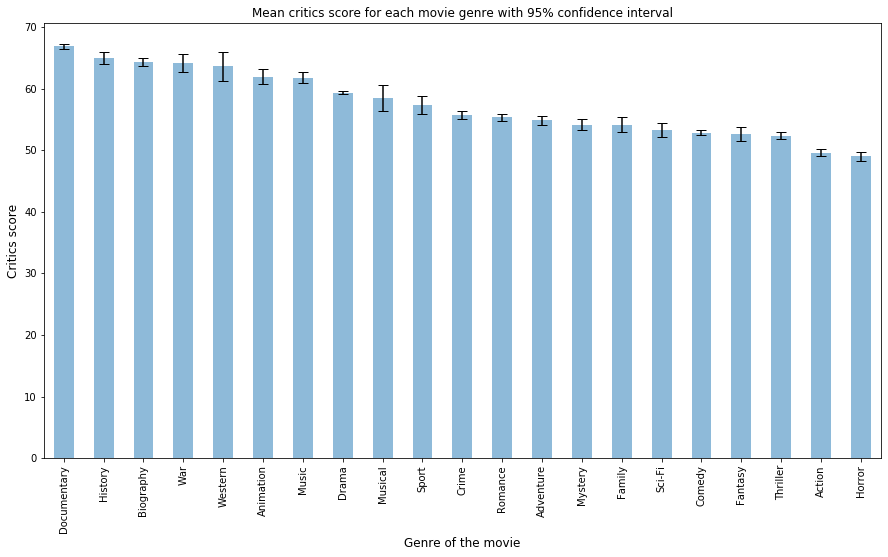

In [313]:
movies_stats_gen_met = genres_success[genres_success['metascore']['cast_count'] > 100]\
                                                    ['metascore']

movies_stats_gen_met['errlo']  = movies_stats_gen_met['nanmean'] - \
                                 movies_stats_gen_met['95% CI mean'].apply(lambda x: x[0])

movies_stats_gen_met['errhi']  = movies_stats_gen_met['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_met['nanmean']

movies_stats_gen_met = movies_stats_gen_met.sort_values('nanmean', ascending=False)

movies_stats_gen_met.plot(kind='bar', y='nanmean', yerr=movies_stats_gen_met[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Critics score", size="large")
plt.title("Mean critics score for each movie genre with 95% confidence interval" , size="large");

## Cast Gender 

### Awards Based

#### Movie Cast Analysis on Unuccessful Movies

In [150]:
movie_cast_expl = unrecognized_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of unsuccessful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of unsuccessful movies considered for cast analysis: 396286


Due to the inner join performed, some missing information in the actors dataset has resulted in a reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [151]:
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0000009,3,1,4,0.750000,0.250000
tt0000147,4,0,4,1.000000,0.000000
tt0000335,14,2,16,0.875000,0.125000
tt0000502,2,0,2,1.000000,0.000000
tt0000574,14,3,17,0.823529,0.176471


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

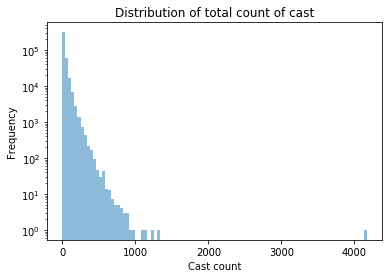

In [152]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

In [631]:
colors = ['#8ebad9', '#ffbe85']

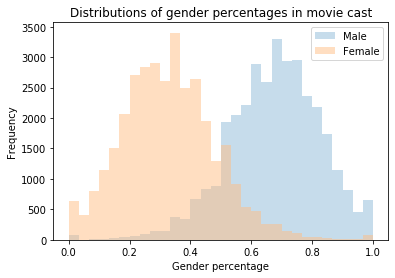

In [632]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage');

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

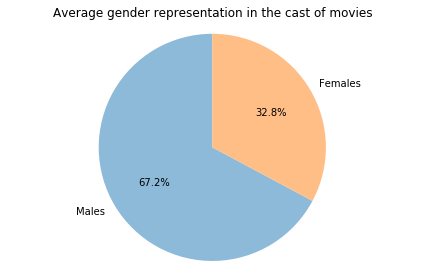

In [633]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [155]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.7058823529411765
Median percentage of females: 0.29411764705882354


Next, we check if this situation is different in the movies that are considered successful in terms of awards recognition.

#### Movie Cast Analysis on Successful Movies

In [156]:
movie_cast_expl = top_recognized_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of successful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of successful movies considered for cast analysis: 2331


Due to the inner join performed, some missing information in the actors dataset has resulted in a slightly reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [157]:
# Groupby will not show when one of the value is 0. so do a pivot
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0025316,102,25,127,0.803150,0.196850
tt0026529,64,11,75,0.853333,0.146667
tt0027300,103,35,138,0.746377,0.253623
tt0029146,73,10,83,0.879518,0.120482
tt0031381,159,77,236,0.673729,0.326271


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

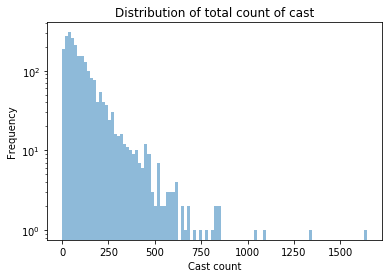

In [158]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count');

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

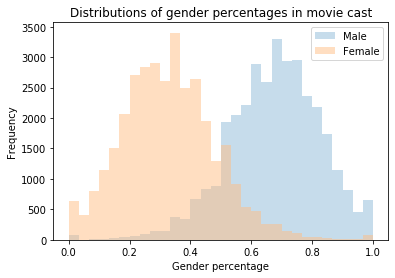

In [634]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage');

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

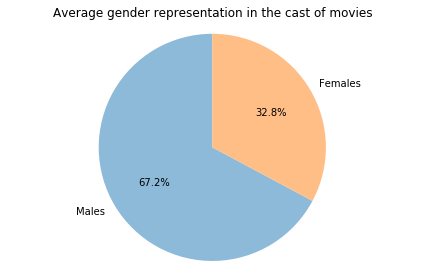

In [635]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [161]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6875
Median percentage of females: 0.3125


In conclusion, both in successful movies as well as unsuccessful movies, in terms of awards, the mean gender percentages of the cast of the movies show little to no difference. Specifically, in successful movies, on average 66.4% of the movie cast are males where as in unsuccessful movies 66.8% of the cast are males. Accordingly, the gender percentages of cast does not seem to make any impact on whether the movie becomes successful in terms of awards

### Popularity Based

#### Movie Cast Analysis on Unuccessful Movies

In [162]:
movie_cast_expl = unpopupar_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of unsuccessful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of unsuccessful movies considered for cast analysis: 210252


Due to the inner join performed, some missing information in the actors dataset has resulted in a reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [163]:
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0000009,3,1,4,0.750000,0.250000
tt0000147,4,0,4,1.000000,0.000000
tt0000335,14,2,16,0.875000,0.125000
tt0000574,14,3,17,0.823529,0.176471
tt0000615,6,1,7,0.857143,0.142857


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.



Text(0.5, 0, 'Cast count')

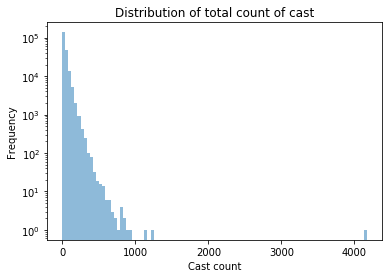

In [164]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

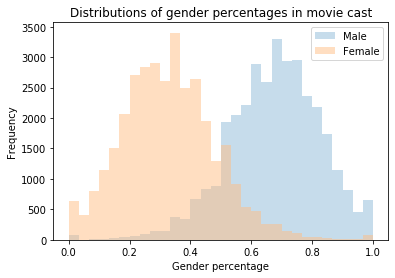

In [636]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

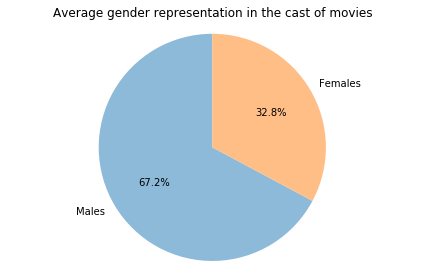

In [637]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [167]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.7083333333333334
Median percentage of females: 0.2916666666666667


Next, we check if this situation is different in the movies that are considered successful in terms of awards recognition.

#### Movie Cast Analysis on Successful Movies

In [168]:
movie_cast_expl = top_popular_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of successful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of successful movies considered for cast analysis: 12002


Due to the inner join performed, some missing information in the actors dataset has resulted in a slightly reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [169]:
# Groupby will not show when one of the value is 0. so do a pivot
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0004972,83,22,105,0.790476,0.209524
tt0006864,158,72,230,0.686957,0.313043
tt0009611,73,1,74,0.986486,0.013514
tt0009968,52,10,62,0.838710,0.161290
tt0010323,16,3,19,0.842105,0.157895


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

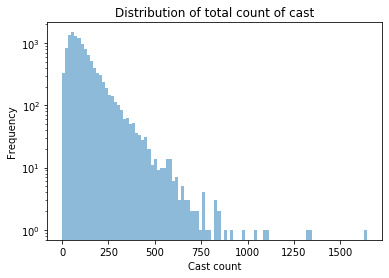

In [170]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

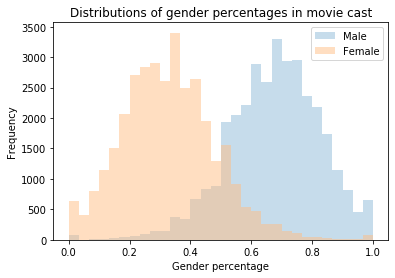

In [639]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage');

In general females are underrepresented in the cast of popular movies as well. The following pie chart demonstrates the mean representation percentage of both the genders.

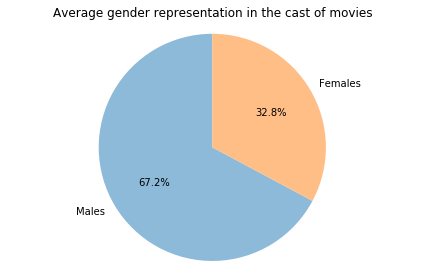

In [640]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [173]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.7142857142857143
Median percentage of females: 0.2857142857142857


In conclusion, both in successful movies as well as unsuccessful movies, in terms of popularity, the mean gender percentages of the cast of the movies show little difference. Specifically, in successful movies, on average 68.5% of the movie cast are males where as in unsuccessful movies 67.1% of the cast are males. Accordingly, the gender percentages of cast does not seem to make any impact on whether the movie becomes successful in terms of popularity.

### Revenue Based

#### Movie Cast Analysis on Unsuccessful Movies

In [174]:

loss_movies_exp = loss_movies.explode('cast')
loss_movies_exp = loss_movies_exp.merge(actors, left_on='cast', right_on='nconst', how='inner')

tconst_genders = loss_movies_exp.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0000009,3,1,4,0.750000,0.250000
tt0000147,8,0,8,1.000000,0.000000
tt0000335,28,4,32,0.875000,0.125000
tt0000502,2,0,2,1.000000,0.000000
tt0000574,14,3,17,0.823529,0.176471
...,...,...,...,...,...
tt9916538,13,6,19,0.684211,0.315789
tt9916622,3,0,3,1.000000,0.000000
tt9916680,15,4,19,0.789474,0.210526


Text(0.5, 0, 'Cast count')

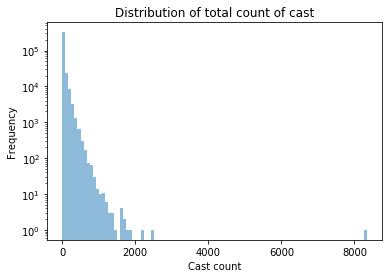

In [175]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count');

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

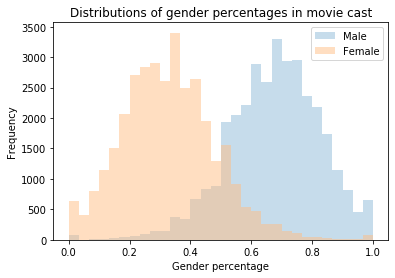

In [641]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage');

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

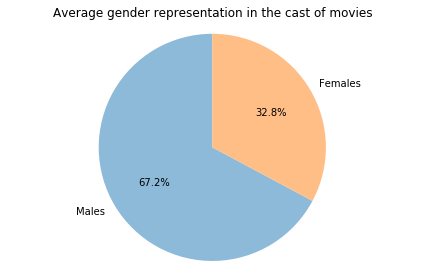

In [642]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [178]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.7111111111111111
Median percentage of females: 0.28888888888888886


Next, we check if this situation is different in the movies that are considered successful in terms of revenue.

#### Movie Cast Analysis on Successful Movies

In [179]:
top_profit_movies_exp = top_profit_movies.explode('cast')
top_profit_movies_exp = top_profit_movies_exp.merge(actors, left_on='cast', right_on='nconst', how='inner')

tconst_genders = top_profit_movies_exp.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0035423,344,212,556,0.618705,0.381295
tt0052679,18,5,23,0.782609,0.217391
tt0052698,39,8,47,0.829787,0.170213
tt0053459,96,40,136,0.705882,0.294118
tt0053472,192,36,228,0.842105,0.157895
...,...,...,...,...,...
tt9905412,9,7,16,0.562500,0.437500
tt9908960,11,3,14,0.785714,0.214286
tt9910502,44,24,68,0.647059,0.352941


Text(0.5, 0, 'Cast count')

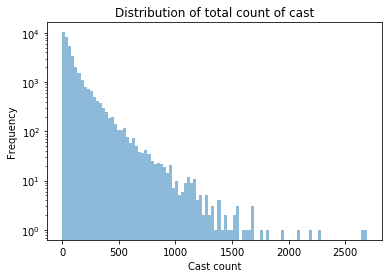

In [180]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5, colors=colors)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can still see that in a significant number of movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

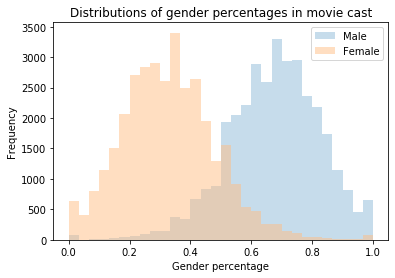

In [644]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage');

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

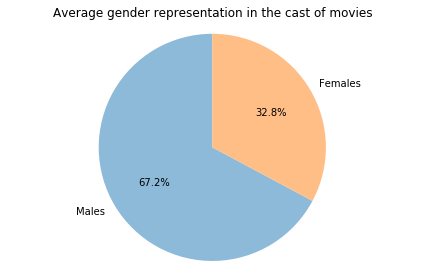

In [645]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [183]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6875
Median percentage of females: 0.3125


In conclusion, we can see that in Financially successful movies, there is a slightly higher percentage of male actors in the movie cast than in not so successful movies.

### Metacritic score Based

#### Movie Cast Analysis on Unsuccessful Movies

In [184]:
low_meta_movies_exp = low_meta_movies.explode('cast')
low_meta_movies_exp = low_meta_movies_exp.merge(actors, left_on='cast', right_on='nconst', how='inner')

tconst_genders = low_meta_movies_exp.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0000009,3,1,4,0.750000,0.250000
tt0000147,8,0,8,1.000000,0.000000
tt0000335,28,4,32,0.875000,0.125000
tt0000502,2,0,2,1.000000,0.000000
tt0000574,14,3,17,0.823529,0.176471
...,...,...,...,...,...
tt9916538,13,6,19,0.684211,0.315789
tt9916622,3,0,3,1.000000,0.000000
tt9916680,15,4,19,0.789474,0.210526


Text(0.5, 0, 'Cast count')

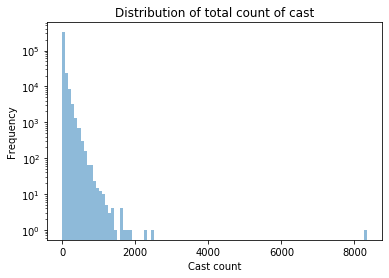

In [185]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5, colors=colors)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

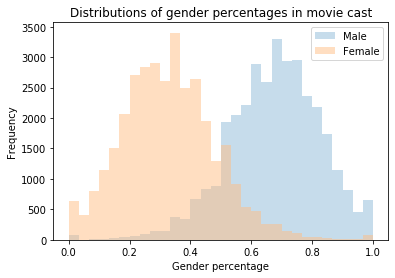

In [647]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage');

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

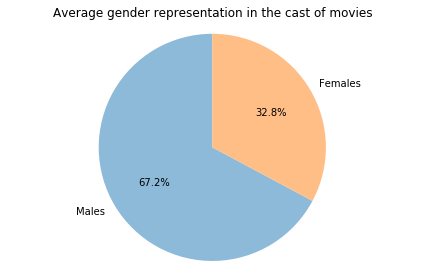

In [648]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [188]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.7142857142857143
Median percentage of females: 0.2857142857142857


Next, we check if this situation is different in the movies that are considered successful in terms of metascore.

#### Movie Cast Analysis on Successful Movies

In [189]:
top_meta_movies_exp = top_meta_movies.explode('cast')
top_meta_movies_exp = top_meta_movies_exp.merge(actors, left_on='cast', right_on='nconst', how='inner')

tconst_genders = top_meta_movies_exp.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0004972,83,22,105,0.790476,0.209524
tt0006864,158,72,230,0.686957,0.313043
tt0011317,16,7,23,0.695652,0.304348
tt0011870,52,24,76,0.684211,0.315789
tt0012349,52,39,91,0.571429,0.428571
...,...,...,...,...,...
tt9885292,3,0,3,1.000000,0.000000
tt9894470,196,52,248,0.790323,0.209677
tt9899726,6,3,9,0.666667,0.333333


Text(0.5, 0, 'Cast count')

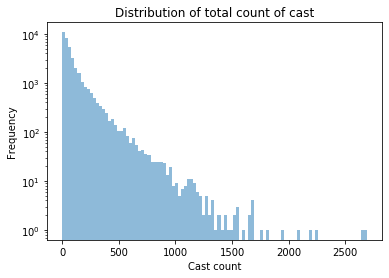

In [190]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5, colors=colors)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can still see that in a significant number of movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

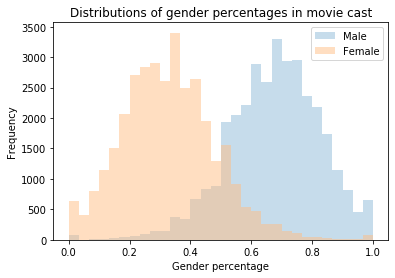

In [649]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5, colors=colors)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

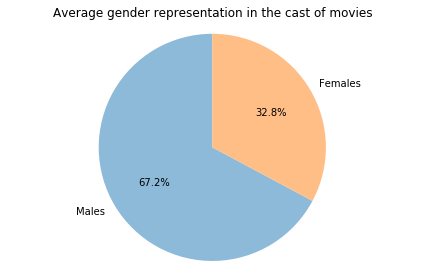

In [650]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [193]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6785714285714286
Median percentage of females: 0.32142857142857145


In conclusion, we can see that there is almost no difference between the cast gender percetages of successful movies and the unsuccessful movies based on the metacritic score.

## Plots among metrics

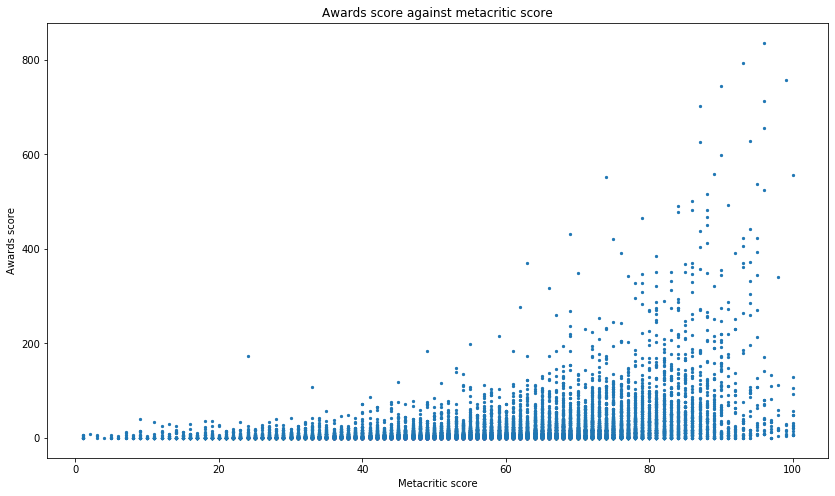

In [194]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

In [195]:
top_recognized_movies = top_recognized_movies.dropna(subset=['numVotes'])
recognized_pop_movies = top_recognized_movies.sort_values('numVotes', ascending=False)


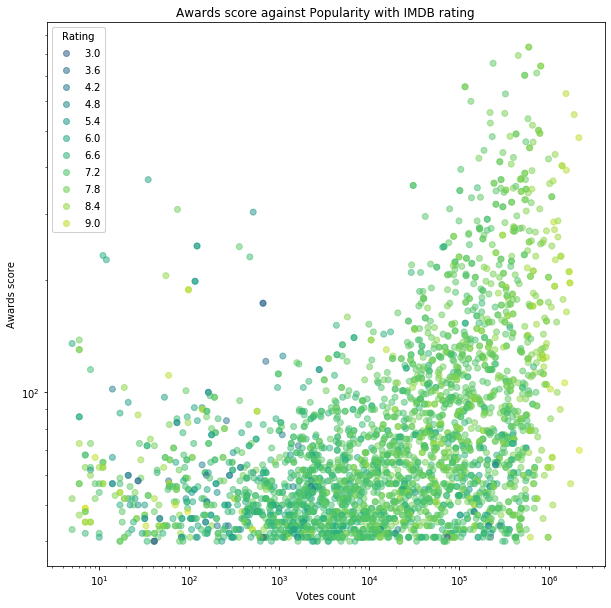

In [196]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

scatter = ax.scatter(top_recognized_movies['numVotes'],
            top_recognized_movies['recognition'],
            alpha=0.5,
            c=top_recognized_movies['averageRating'],
            vmin=0, vmax=10)
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper left", title="Rating")
ax.add_artist(legend1)
ax.set_title("Awards score against Popularity with IMDB rating")    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Votes count')
ax.set_ylabel('Awards score')
# ax.set_ylim(bottom=1)
plt.show()

## Geographical reach

We change the name of titleId to tconst to make consistent with the other dataframes, we also remove all the \N regions.

In [256]:
movie_akas = pd.read_csv("data/title.akas.tsv.gz", sep='\t')
country_codes = pd.read_csv('data/countries.csv')

In [257]:
country_codes.columns=['region','country']

In [258]:
movie_akas = movie_akas.rename(columns={'titleId': 'tconst'})
movie_akas = movie_akas.drop(movie_akas[movie_akas.region == r'\N'].index,axis=0)

To have the complete name of each country

In [259]:
movie_akas = movie_akas.merge(country_codes, how='inner', on='region')
movie_akas.drop('region',axis=1,inplace=True)

We get the number of countries a given movie was released

In [262]:
unique_regions = movie_akas.groupby('tconst').agg({'country': 'nunique'})
unique_regions = unique_regions.reset_index()
unique_regions.columns=['tconst','region']

In [219]:
recognized_movies = recognized_movies.merge(unique_regions, how='inner', on='tconst')

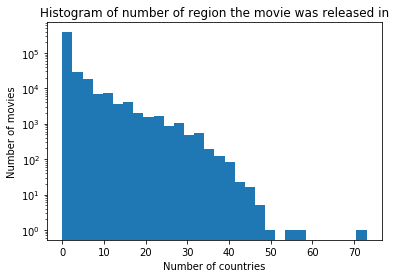

In [265]:
plt.hist(recognized_movies['region'], bins=30)
plt.yscale('log')
plt.title('Histogram of number of region the movie was released in')
plt.xlabel('Number of countries')
plt.ylabel('Number of movies')
plt.show()

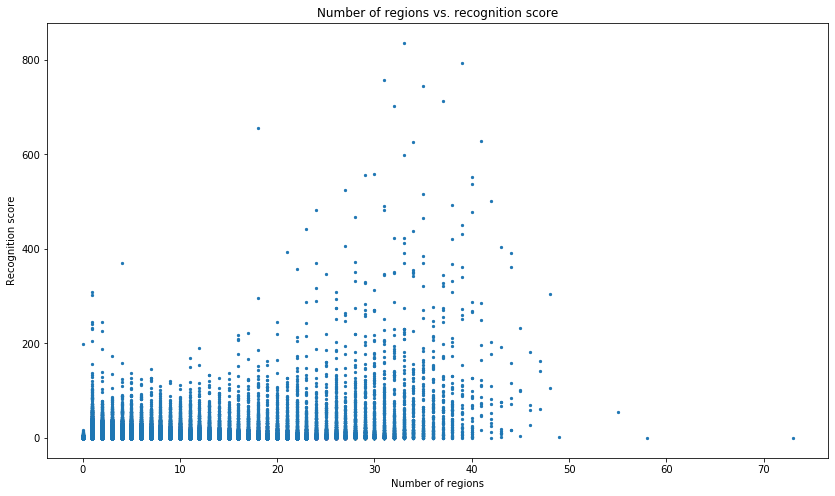

In [266]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['recognition'], s=5);

plt.title("Number of regions vs. recognition score")
plt.xlabel('Number of regions')
plt.ylabel('Recognition score');

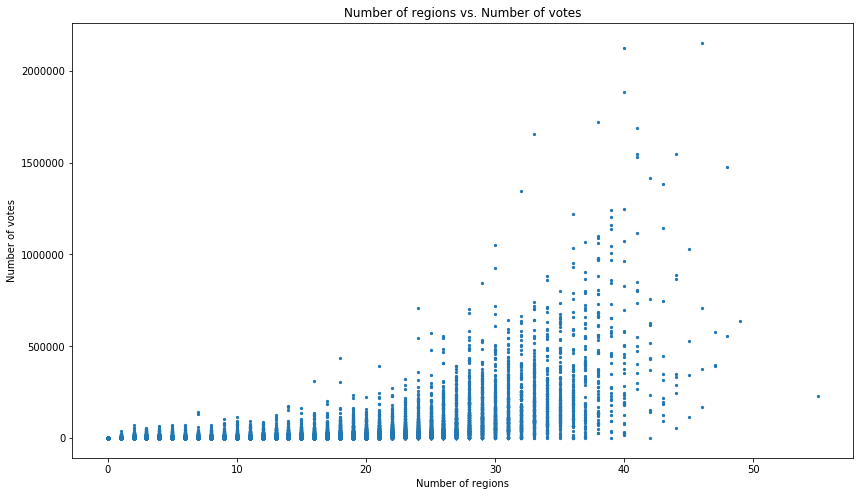

In [267]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['numVotes'], s=5);

plt.title("Number of regions vs. Number of votes")
plt.xlabel('Number of regions')
plt.ylabel('Number of votes');

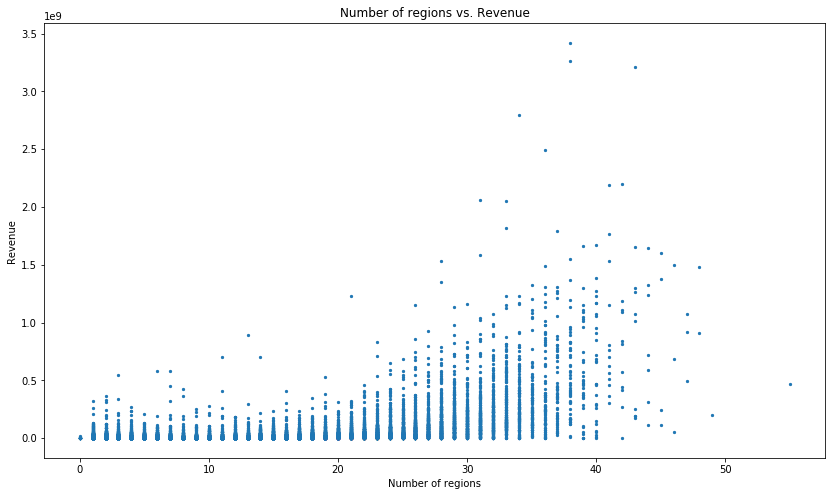

In [268]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Number of regions vs. Revenue")
plt.xlabel('Number of regions')
plt.ylabel('Revenue');

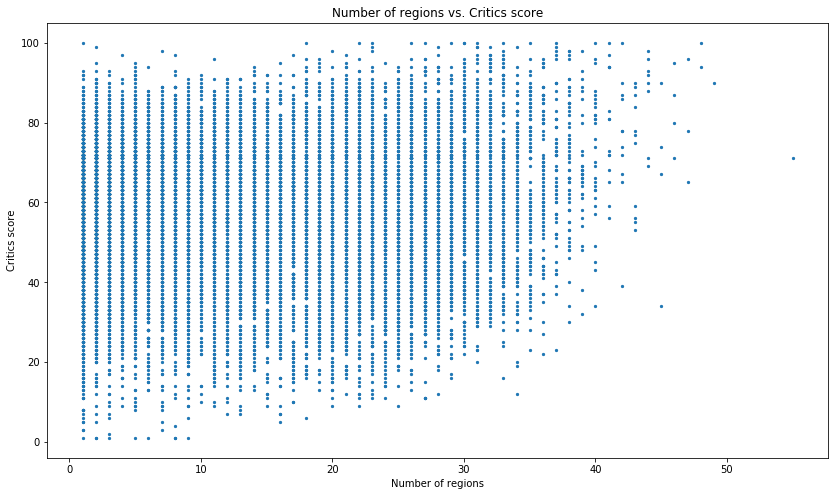

In [269]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['metascore'], s=5);

plt.title("Number of regions vs. Critics score")
plt.xlabel('Number of regions')
plt.ylabel('Critics score');

In [270]:
intervals = [0,10,20,30,40,80]
movies_stats_regions = recognized_movies.groupby(pd.cut(recognized_movies['region'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted', 'metascore']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_regions = movies_stats_regions.rename(columns={'<lambda_0>': '95% CI mean', \
                                                            '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [271]:
movies_stats_regions['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
region,,,,,,,,,,,,
"(0, 10]",432458.0,0.780561,4.242333,0.0,370.0,0.0,"[0.771, 0.791]","[0.0, 0.0]",0.0,0.0,4.00,18.00
"(10, 20]",14844.0,5.431420,15.743363,0.0,655.0,0.0,"[5.226, 5.665]","[0.0, 0.0]",4.0,16.0,29.85,71.00
"(20, 30]",4544.0,17.950044,41.104564,0.0,559.0,4.0,"[17.002, 18.914]","[4.0, 5.0]",17.0,46.0,78.00,205.57
"(30, 40]",1151.0,59.415291,100.546133,0.0,836.0,21.0,"[54.89, 64.391]","[19.0, 23.0]",68.5,148.0,251.50,491.00
"(40, 80]",63.0,115.857143,127.359645,0.0,628.0,75.0,"[91.414, 143.216]","[61.0, 102.0]",160.0,277.8,389.00,549.26


In [272]:
movies_stats_regions['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
region,,,,,,,,,,,,
"(0, 10]",202026.0,335.632364,1721.981881,5.0,143217.0,37.0,"[329.261, 341.941]","[37.0, 38.0]",155.00,590.0,1291.0,5215.50
"(10, 20]",14766.0,6269.424353,14676.880678,5.0,435213.0,1770.0,"[6068.625, 6459.365]","[1726.9, 1821.025]",5527.25,15139.5,27272.5,71203.60
"(20, 30]",4535.0,55850.751929,81052.195593,11.0,1050621.0,27390.0,"[53865.93, 57830.051]","[26084.7, 28703.1]",69323.00,140580.4,209956.4,403410.84
"(30, 40]",1148.0,236074.405052,238284.760207,17.0,2126738.0,164748.5,"[224996.106, 248561.357]","[153039.375, 171165.25]",311623.00,547669.6,686612.9,1097059.81
"(40, 80]",61.0,608073.360656,471420.080990,1772.0,2153889.0,446370.0,"[520232.02, 709456.548]","[372993.5, 554599.15]",798362.00,1418060.0,1545029.0,1875690.00


In [273]:
movies_stats_regions['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
region,,,,,,,,,,,,
"(0, 10]",27768.0,3.090243e+06,1.407631e+07,0.00,5.794224e+08,2.194386e+05,"[2944634.817, 3223405.239]","[211092.645, 227095.68]",1.480811e+06,5.986148e+06,1.316671e+07,4.731850e+07
"(10, 20]",5705.0,1.443895e+07,3.465846e+07,3.05,8.915839e+08,3.275947e+06,"[13684778.078, 15233825.184]","[3087141.503, 3422068.55]",1.409995e+07,3.809992e+07,6.294288e+07,1.506072e+08
"(20, 30]",3350.0,9.004484e+07,1.290039e+08,1283.27,1.528049e+09,4.592419e+07,"[86400550.855, 93819134.584]","[43040023.54, 48437485.316]",1.105056e+08,2.253312e+08,3.215298e+08,6.436244e+08
"(30, 40]",1042.0,3.283562e+08,3.542071e+08,6077.42,3.421994e+09,2.169508e+08,"[311101103.614, 345607561.001]","[202160194.17, 229340207.45]",4.173202e+08,7.591182e+08,1.019084e+09,1.568843e+09
"(40, 80]",55.0,8.729582e+08,6.378110e+08,66045.51,3.213030e+09,7.594594e+08,"[734100594.517, 1002473162.675]","[569889033.1, 967179562.709]",1.251759e+09,1.626494e+09,1.896142e+09,2.665247e+09


In [274]:
movies_stats_regions['metascore']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
region,,,,,,,,,,,,
"(0, 10]",6900.0,57.404058,16.681960,1.0,100.0,60.0,"[57.082, 57.738]","[59.0, 60.0]",70.0,77.0,81.0,88.0
"(10, 20]",3700.0,56.339459,17.879063,5.0,100.0,58.0,"[55.858, 56.804]","[57.0, 58.0]",70.0,79.0,83.0,90.0
"(20, 30]",3086.0,56.487362,18.236436,9.0,100.0,57.0,"[55.98, 56.97]","[56.0, 57.525]",70.0,81.0,86.0,94.0
"(30, 40]",1067.0,63.103093,17.825574,12.0,100.0,63.0,"[62.199, 63.98]","[62.0, 65.0]",76.0,87.0,92.0,98.0
"(40, 80]",60.0,78.616667,15.102017,34.0,100.0,79.0,"[75.387, 81.836]","[74.0, 87.0]",90.0,96.0,98.1,100.0


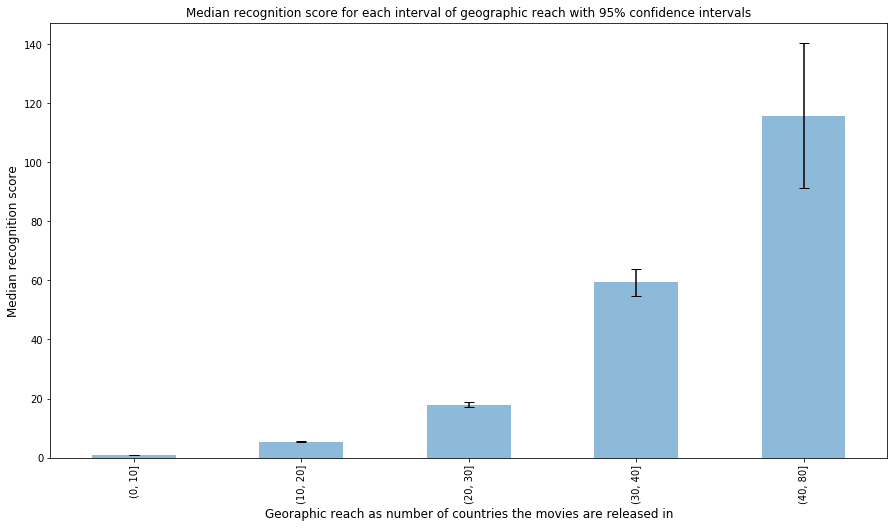

In [275]:
movies_stats_regions_rec = movies_stats_regions['recognition']
movies_stats_regions_rec['errlo']  = movies_stats_regions_rec['nanmean'] - \
                                 movies_stats_regions_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_regions_rec['errhi']  = movies_stats_regions_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_regions_rec['nanmean']

movies_stats_regions_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_regions_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Median recognition score", size="large")
plt.title("Median recognition score for each interval of geographic reach with 95% confidence" +\
          " intervals" , size="large");

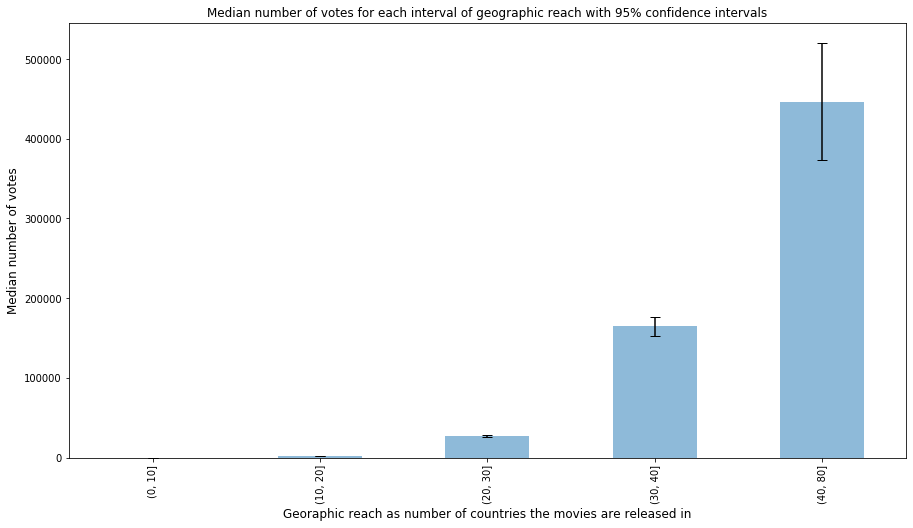

In [276]:
movies_stats_regions_votes = movies_stats_regions['numVotes']
movies_stats_regions_votes['errlo']  = movies_stats_regions_votes['nanmedian'] - \
                                 movies_stats_regions_votes['95% CI median'].apply(lambda x: x[0])

movies_stats_regions_votes['errhi']  = movies_stats_regions_votes['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_regions_votes['nanmedian']

movies_stats_regions_votes.plot(kind='bar', y='nanmedian', \
                                yerr=movies_stats_regions_votes[['errlo','errhi']].T.values,\
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes for each interval of geographic reach with 95% confidence" +\
          " intervals" , size="large");

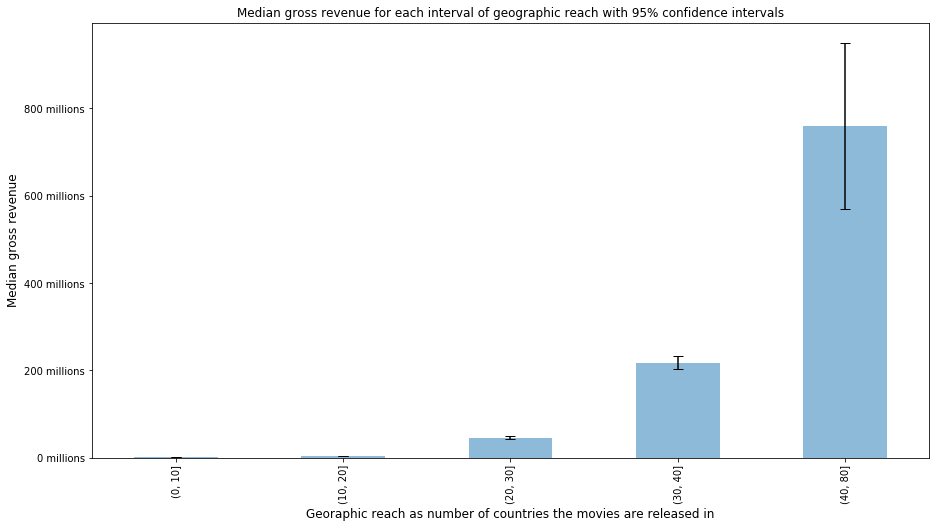

In [341]:
movies_stats_regions_gross = movies_stats_regions['worldwideGross_adjusted']
movies_stats_regions_gross['errlo']  = movies_stats_regions_gross['nanmedian'] - \
                                 movies_stats_regions_gross['95% CI median'].apply(lambda x: x[0])

movies_stats_regions_gross['errhi']  = movies_stats_regions_gross['95% CI median'].apply(lambda x: x[1]) - \
                                 movies_stats_regions_gross['nanmedian']

g=movies_stats_regions_gross.plot(kind='bar', y='nanmedian', \
                                  yerr=movies_stats_regions_gross[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Median gross revenue", size="large")
plt.title("Median gross revenue for each interval of geographic reach with 95% confidence" + \
          " intervals" , size="large");
ylabels = ['{:,.0f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

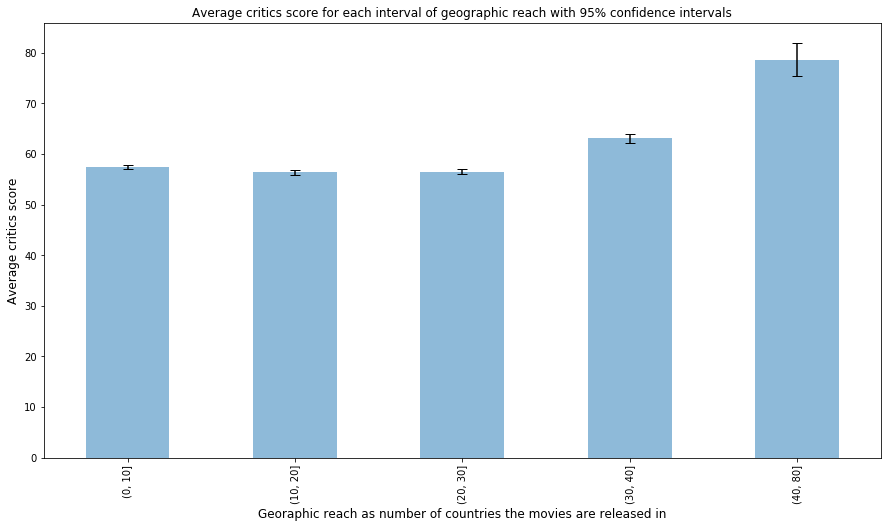

In [278]:
movies_stats_regions_met = movies_stats_regions['metascore']
movies_stats_regions_met['errlo']  = movies_stats_regions_met['nanmean'] - \
                                 movies_stats_regions_met['95% CI mean'].apply(lambda x: x[0])

movies_stats_regions_met['errhi']  = movies_stats_regions_met['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_regions_met['nanmean']

movies_stats_regions_met.plot(kind='bar', y='nanmean', yerr=movies_stats_regions_met[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Average critics score", size="large")
plt.title("Average critics score for each interval of geographic reach with 95% confidence" +\
          " intervals" , size="large");

## Budget 

We only keep the movies budget in dollars and we adjust for the inflation 

In [281]:
recognized_movies['budget_adjusted'] = recognized_movies['budget'].apply(keep_numbers)
recognized_movies['budget_adjusted'] = normalize_inflation(recognized_movies['budget_adjusted'],\
                                                                   recognized_movies['year'])

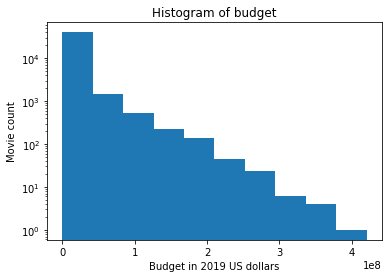

In [283]:
plt.hist(recognized_movies.budget_adjusted, bins=10)
plt.yscale('log')
plt.title('Histogram of budget')
plt.xlabel('Budget in 2019 US dollars')
plt.ylabel('Movie count')
plt.show()

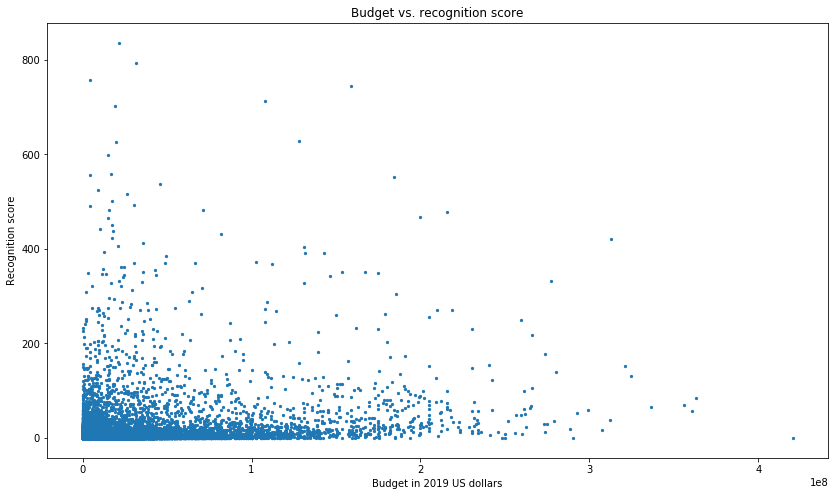

In [287]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['budget_adjusted'],\
            recognized_movies['recognition'], s=5);

plt.title("Budget vs. recognition score")
#plt.yscale('symlog')
plt.xlabel('Budget in 2019 US dollars')
plt.ylabel('Recognition score');

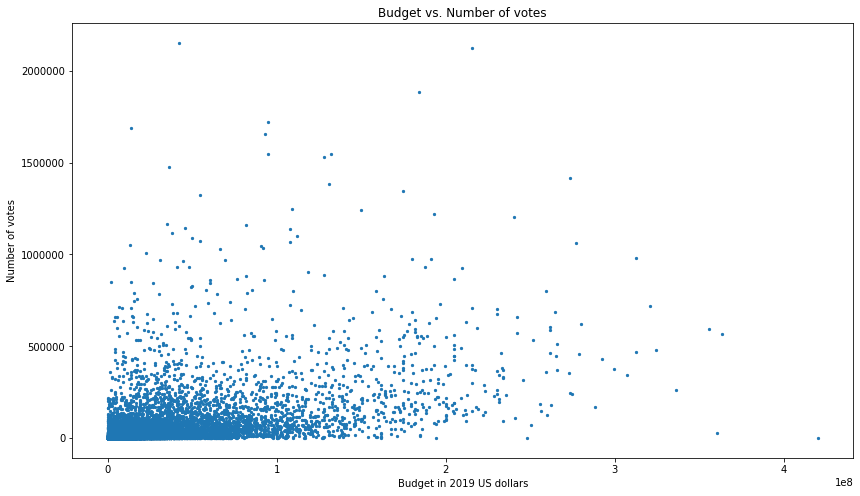

In [288]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['budget_adjusted'],\
            recognized_movies['numVotes'], s=5);

plt.title("Budget vs. Number of votes")
#plt.yscale('symlog')
plt.xlabel('Budget in 2019 US dollars')
plt.ylabel('Number of votes');

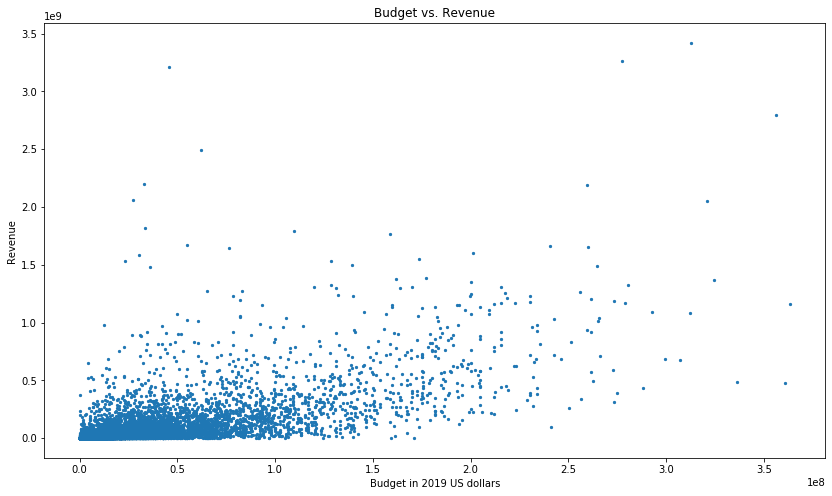

In [290]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['budget_adjusted'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Budget vs. Revenue")
#plt.yscale('symlog')
plt.xlabel('Budget in 2019 US dollars')
plt.ylabel('Revenue');

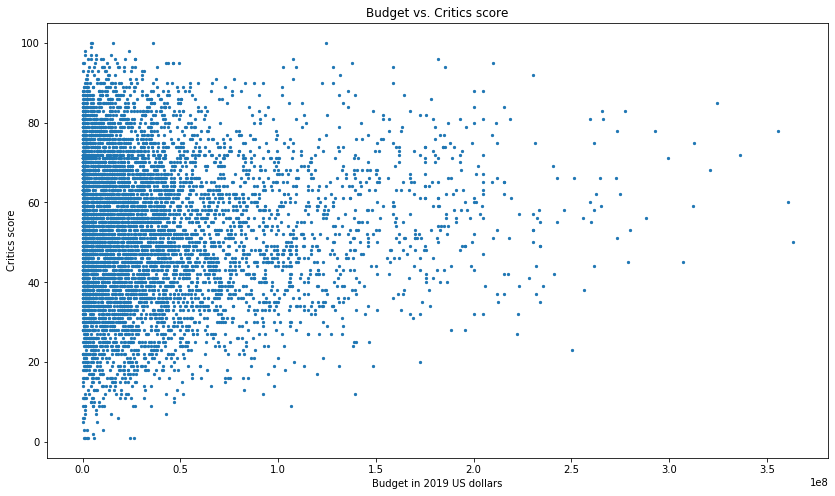

In [291]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['budget_adjusted'],\
            recognized_movies['metascore'], s=5);

plt.title("Budget vs. Critics score")
plt.xlabel('Budget in 2019 US dollars')
plt.ylabel('Critics score');

In [292]:
intervals=[i*10**8 for i in [0,0.25,0.5,0.75,1,1.5,2,5]]
movies_stats_budget = recognized_movies.groupby(pd.cut(recognized_movies['budget_adjusted'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted', 'metascore']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_budget = movies_stats_budget.rename(columns={'<lambda_0>': '95% CI mean', \
                                                          '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

new_indices = ["(0, 25]", "(25, 50]", "(50, 75]", "(75, 100]", "(100, 150]", "(150, 200]", "(200, 500]"]
movies_stats_budget.index = new_indices

In [302]:
movies_stats_budget['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
"(0, 25]",38029.0,2.778038,18.386283,0.0,836.0,0.0,"[2.628, 2.931]","[0.0, 0.0]",0.0,4.0,12.00,53.00
"(25, 50]",2064.0,17.155039,48.798717,0.0,794.0,3.0,"[15.469, 18.999]","[3.0, 3.0]",12.0,39.7,86.00,249.11
"(50, 75]",796.0,18.442211,41.724378,0.0,482.0,5.5,"[15.99, 20.761]","[4.0, 6.0]",16.0,46.5,89.25,208.65
"(75, 100]",444.0,21.288288,38.992478,0.0,432.0,8.0,"[18.331, 24.261]","[7.0, 10.0]",22.0,54.7,90.70,180.99
"(100, 150]",413.0,35.975787,75.093530,0.0,713.0,13.0,"[30.227, 42.548]","[12.0, 15.0]",31.0,73.8,133.20,388.72
"(150, 200]",197.0,61.258883,92.536584,0.0,744.0,31.0,"[51.006, 72.488]","[25.0, 40.0]",77.0,115.8,231.40,470.40
"(200, 500]",101.0,72.910891,85.834736,0.0,479.0,48.0,"[59.026, 87.09]","[35.0, 57.0]",79.0,154.0,255.00,420.00


In [303]:
movies_stats_budget['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
"(0, 25]",23057.0,7347.327363,38842.058991,5.0,1690224.0,92.0,"[6924.013, 7772.214]","[87.0, 96.0]",1066.00,10372.2,32741.00,138381.88
"(25, 50]",2034.0,68695.054572,130928.528695,7.0,2153889.0,25609.0,"[63693.782, 73659.25]","[23920.175, 27655.05]",73538.25,171185.4,272740.45,612793.41
"(50, 75]",785.0,95111.861146,136844.439734,6.0,1323467.0,52118.0,"[87622.515, 103597.979]","[48370.225, 56908.3]",119022.00,221899.0,309453.60,749026.48
"(75, 100]",428.0,142355.644860,205187.043027,16.0,1720713.0,83188.0,"[125830.121, 158784.043]","[72985.0, 87439.0]",165727.00,308136.2,439653.55,1043158.21
"(100, 150]",410.0,178977.019512,215021.062530,156.0,1545029.0,110775.0,"[161147.044, 196280.19]","[97086.375, 118224.475]",224455.75,400065.3,545864.80,1137047.78
"(150, 200]",197.0,299527.253807,266507.832296,167.0,1887822.0,229726.0,"[269137.001, 331484.979]","[205254.0, 247508.7]",395401.00,589975.8,733805.00,1247481.60
"(200, 500]",99.0,400636.262626,312949.119872,267.0,2126738.0,346435.0,"[352764.274, 451912.161]","[286943.925, 376742.0]",510069.00,706236.6,933797.70,1432233.56


In [304]:
movies_stats_budget['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
"(0, 25]",5942.0,2.097351e+07,5.753382e+07,13.77,1.528049e+09,1.867384e+06,"[19845333.248, 22186527.119]","[1709115.13, 2103691.775]",1.743949e+07,5.719814e+07,9.665719e+07,2.722598e+08
"(25, 50]",1812.0,9.253290e+07,1.683289e+08,2849.34,3.213030e+09,4.595809e+07,"[85945326.326, 99302211.366]","[43848322.98, 49814279.36]",1.069427e+08,2.051060e+08,3.075020e+08,7.668120e+08
"(50, 75]",724.0,1.464119e+08,1.883065e+08,54721.41,2.495833e+09,9.371960e+07,"[135356546.418, 158067770.917]","[87419421.49, 103076925.207]",1.876201e+08,3.094595e+08,4.614748e+08,8.333206e+08
"(75, 100]",416.0,2.255629e+08,2.262375e+08,17494.05,1.640748e+09,1.639187e+08,"[207799126.282, 245064297.357]","[149158821.84, 174604944.99]",2.880229e+08,4.837984e+08,6.677001e+08,1.135534e+09
"(100, 150]",395.0,3.109686e+08,2.619160e+08,636931.45,1.790959e+09,2.543197e+08,"[290765514.654, 333360831.288]","[242561457.81, 267747795.46]",4.161335e+08,6.176827e+08,7.811899e+08,1.309454e+09
"(150, 200]",189.0,5.578501e+08,3.331152e+08,797839.00,1.769700e+09,4.955704e+08,"[514576723.906, 597020684.026]","[443966558.464, 555372917.565]",7.577892e+08,1.052225e+09,1.152212e+09,1.406420e+09
"(200, 500]",97.0,8.540372e+08,5.891257e+08,93009245.97,3.421994e+09,7.078575e+08,"[759991655.387, 951662062.907]","[608004878.46, 852964438.12]",1.131288e+09,1.342869e+09,1.738572e+09,3.271802e+09


In [305]:
movies_stats_budget['metascore']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
"(0, 25]",3728.0,54.290236,18.984580,1.0,100.0,55.0,"[53.815, 54.794]","[55.0, 56.0]",68.0,79.0,84.00,93.00
"(25, 50]",1456.0,52.964286,17.651108,1.0,100.0,53.0,"[52.235, 53.701]","[52.0, 54.0]",65.0,76.0,83.00,91.00
"(50, 75]",629.0,51.405405,16.531268,12.0,91.0,50.0,"[50.322, 52.398]","[49.0, 51.525]",63.0,74.0,79.00,88.72
"(75, 100]",384.0,51.505208,16.077488,12.0,91.0,51.5,"[50.102, 52.742]","[48.0, 53.0]",62.0,73.0,77.85,88.34
"(100, 150]",387.0,52.832041,16.541993,9.0,100.0,52.0,"[51.469, 54.156]","[50.0, 53.0]",64.0,73.4,82.70,94.00
"(150, 200]",191.0,59.706806,14.857849,20.0,96.0,59.0,"[57.879, 61.499]","[56.0, 62.0]",72.0,79.0,82.00,94.00
"(200, 500]",97.0,59.082474,15.664231,23.0,95.0,59.0,"[56.781, 61.636]","[56.0, 62.0]",69.0,81.0,83.20,92.12


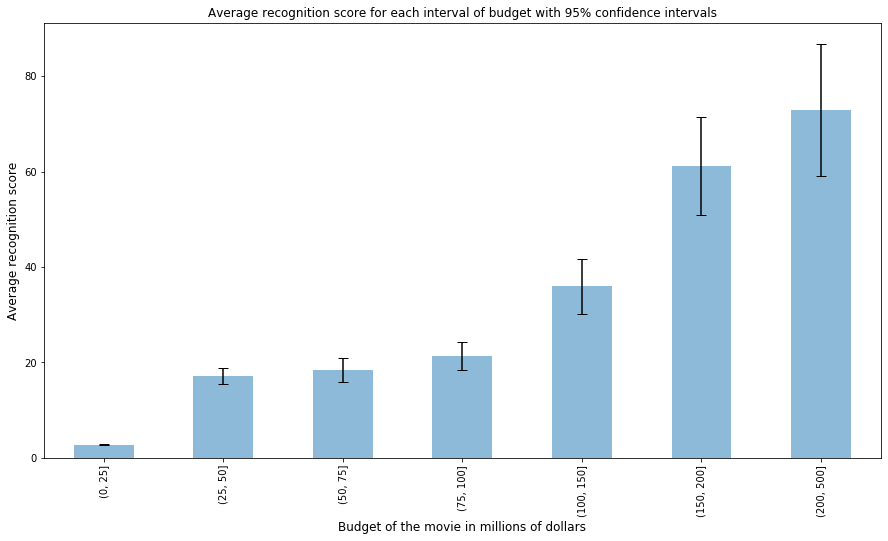

In [309]:
movies_stats_budget_rec = movies_stats_budget['recognition']
movies_stats_budget_rec['errlo']  = movies_stats_budget_rec['nanmean'] - \
                                 movies_stats_budget_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_budget_rec['errhi']  = movies_stats_budget_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_rec['nanmean']

movies_stats_budget_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_budget_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in millions of dollars", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of budget with 95% confidence" +\
          " intervals" , size="large");

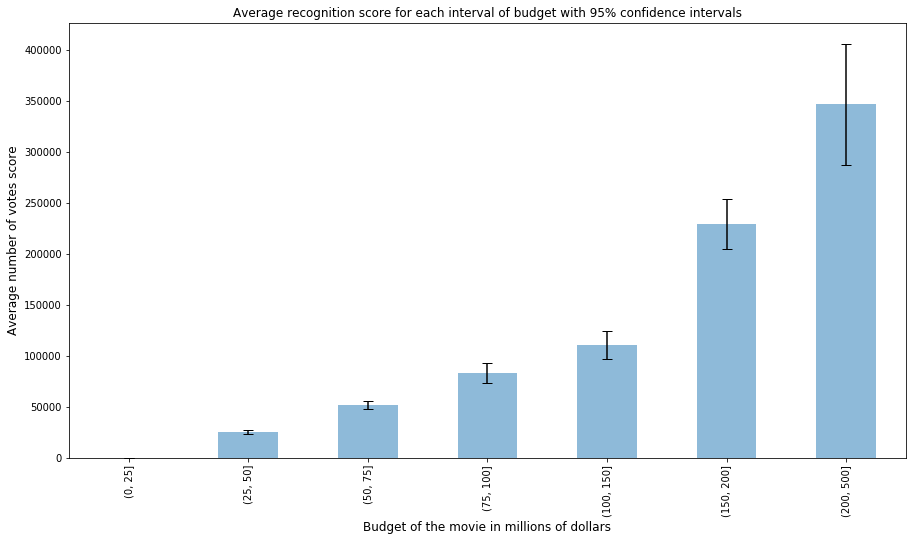

In [308]:
movies_stats_budget_votes = movies_stats_budget['numVotes']
movies_stats_budget_votes['errlo']  = movies_stats_budget_votes['nanmedian'] - \
                                 movies_stats_budget_votes['95% CI median'].apply(lambda x: x[0])

movies_stats_budget_votes['errhi']  = movies_stats_budget_votes['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_votes['nanmedian']

movies_stats_budget_votes.plot(kind='bar', y='nanmedian', \
                               yerr=movies_stats_budget_votes[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in millions of dollars", size='large')
plt.ylabel("Median number of votes score", size="large")
plt.title("Median recognition score for each interval of budget with 95% confidence" +\
          " intervals" , size="large");

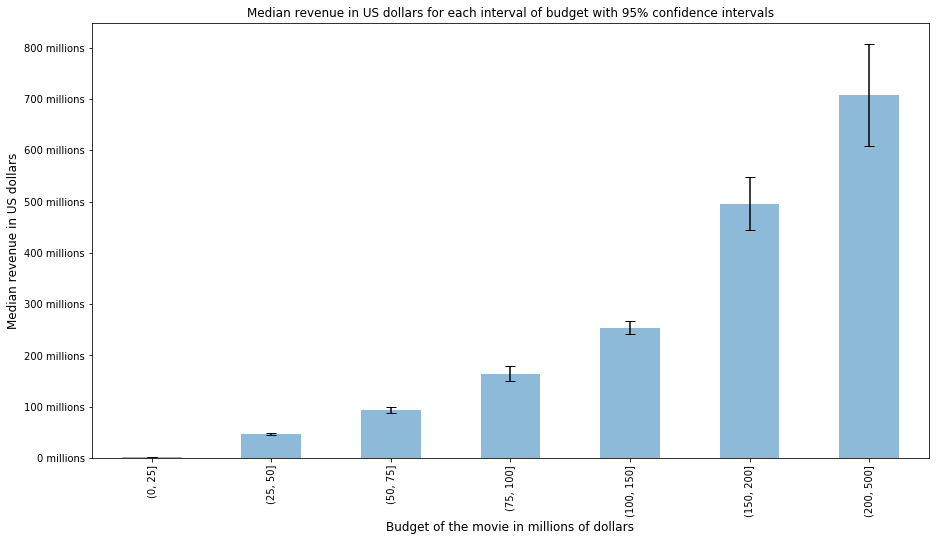

In [345]:
movies_stats_budget_rev = movies_stats_budget['worldwideGross_adjusted']
movies_stats_budget_rev['errlo']  = movies_stats_budget_rev['nanmedian'] - \
                                 movies_stats_budget_rev['95% CI median'].apply(lambda x: x[0])

movies_stats_budget_rev['errhi']  = movies_stats_budget_rev['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_rev['nanmedian']

g = movies_stats_budget_rev.plot(kind='bar', y='nanmedian', \
                               yerr=movies_stats_budget_rev[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in millions of dollars", size='large')
plt.ylabel("Median revenue in US dollars", size="large")
plt.title("Median revenue in US dollars for each interval of budget with 95% confidence" +\
          " intervals" , size="large");
ylabels = ['{:,.0f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

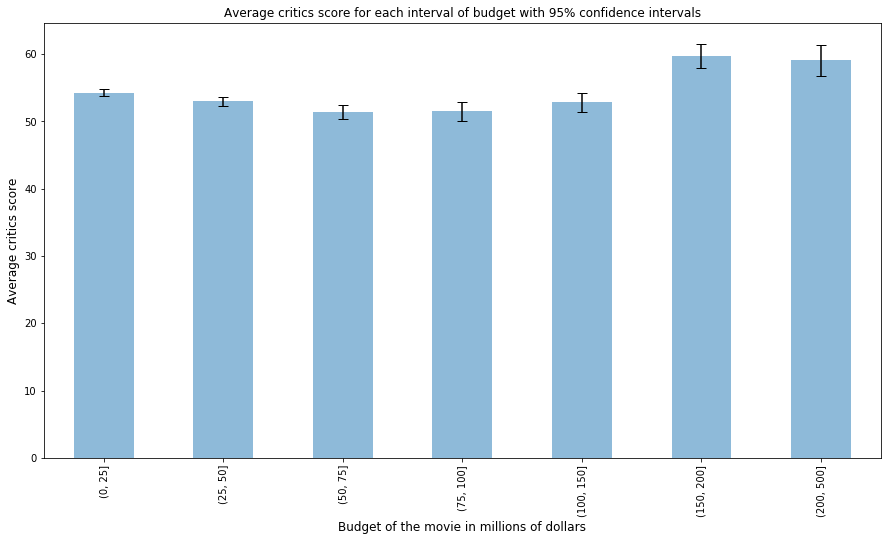

In [346]:
movies_stats_budget_rec = movies_stats_budget['metascore']
movies_stats_budget_rec['errlo']  = movies_stats_budget_rec['nanmean'] - \
                                 movies_stats_budget_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_budget_rec['errhi']  = movies_stats_budget_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_rec['nanmean']

movies_stats_budget_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_budget_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in millions of dollars", size='large')
plt.ylabel("Average critics score", size="large")
plt.title("Average critics score for each interval of budget with 95% confidence" +\
          " intervals" , size="large");

## Actors

Here is the list of the 10 most important actor awards

In [378]:
Awards = ['Oscar',"Palme d Or",'BAFTA Film Award','Golden Berlin Bear','Filmfare Award',\
        'European Film Award','Golden Leopard','Grand Jury Prize','Golden Globe','Golden Lion']

In [362]:
recognized_movies['year_actors'] = recognized_movies['year'].apply(lambda x: no_null(x))

In [365]:
actors_awards = actors_awards[actors_awards.apply(lambda x: x.category in Awards , axis=1)]

In [379]:
actors_awards['category2']=actors_awards.apply(lambda x:  x['category'].replace("'",' ') ,axis=1)

In [374]:
actors_awards['category'].value_counts()

Golden Globe           6116
Oscar                  3995
BAFTA Film Award       2444
Filmfare Award         1684
Grand Jury Prize       1201
Palme d'Or             1027
European Film Award     835
Golden Lion             833
Golden Berlin Bear      793
Golden Leopard          224
Name: category, dtype: int64

In [387]:
test = recognized_movies[10000:10010]
%timeit test['cast_score'] = test.apply(lambda x: cumulated_score(actors_awards, x['cast'],\
                                                                          x['startYear']), axis=1)

979 ms ± 58.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [386]:
27000/600

45.0

In [ ]:
c

## Directors 

In [542]:
top_n = 1000

In [ ]:
recognized_movies = recognized_movies.merge(crew[['tconst', 'directors']], on='tconst', how='left')

In [545]:
#We take the first top_n with respect to each metric
top_recognition = recognized_movies.sort_values('recognition', ascending=False).head(top_n)
top_numVotes = recognized_movies.sort_values('numVotes', ascending=False).head(top_n)
top_revenue = recognized_movies.sort_values('worldwideGross_adjusted', ascending=False).head(top_n)
top_metascore = recognized_movies.sort_values('metascore', ascending=False).head(top_n)

In [548]:
top_recognition['director_score'] = top_recognition.apply(lambda x: director_score(top_recognition,\
                                                                    x['directors'], x['year']), axis=1)
top_numVotes['director_score'] = top_numVotes.apply(lambda x: director_score(top_numVotes,\
                                                                    x['directors'], x['year']), axis=1)
top_revenue['director_score'] = top_revenue.apply(lambda x: director_score(top_revenue,\
                                                                    x['directors'], x['year']), axis=1)
top_metascore['director_score'] = top_metascore.apply(lambda x: director_score(top_metascore,\
                                                                    x['directors'], x['year']), axis=1)

In [571]:
top_recognition[(top_recognition['recognition'] > 700)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values

array([['12 Years a Slave', 42.5, 836.0],
       ['La La Land', 36.5, 794.0],
       ['Moonlight', nan, 757.0],
       ['Mad Max: Fury Road', 40.0, 744.0],
       ['Gravity', nan, 713.0],
       ['Birdman or (The Unexpected Virtue of Ignorance)', 45.0, 703.0]],
      dtype=object)

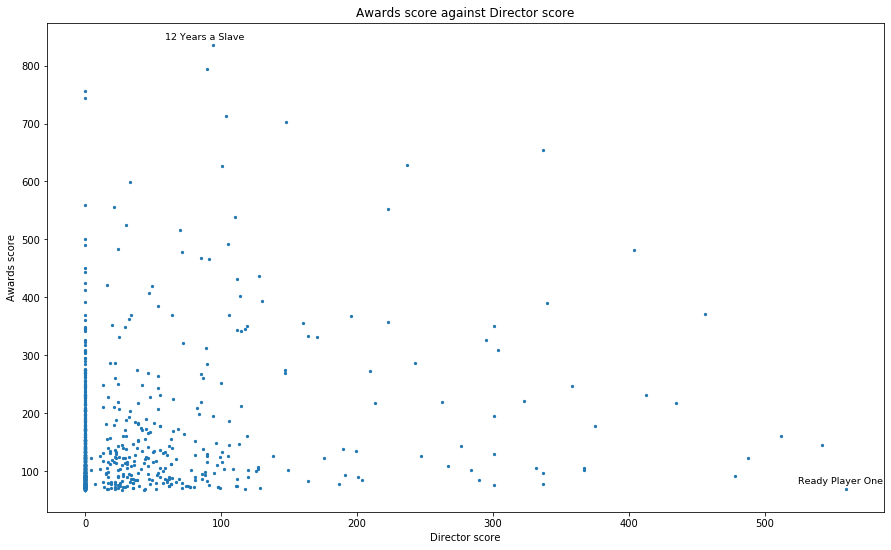

In [586]:
fig = plt.figure(figsize=(15,9))

plt.scatter(top_recognition['director_score'],\
            top_recognition['recognition'], s=5);
plt.title("Awards score against Director score") 

annotations = []
annotations.append(top_recognition[(top_recognition['recognition'] > 800)]\
                 [['primaryTitle', 'director_score', 'recognition']].values)
annotations.append(top_recognition[(top_recognition['recognition'] < 100) &\
                                   (top_recognition['director_score'] > 500)]\
                 [['primaryTitle', 'director_score', 'recognition']].values)

annotations = [item for sublist in annotations for item in sublist]

for title, x, y in annotations:
    plt.text(x-35, y + 10, title, fontsize=9.5)

plt.xlabel('Director score')
plt.ylabel('Awards score');

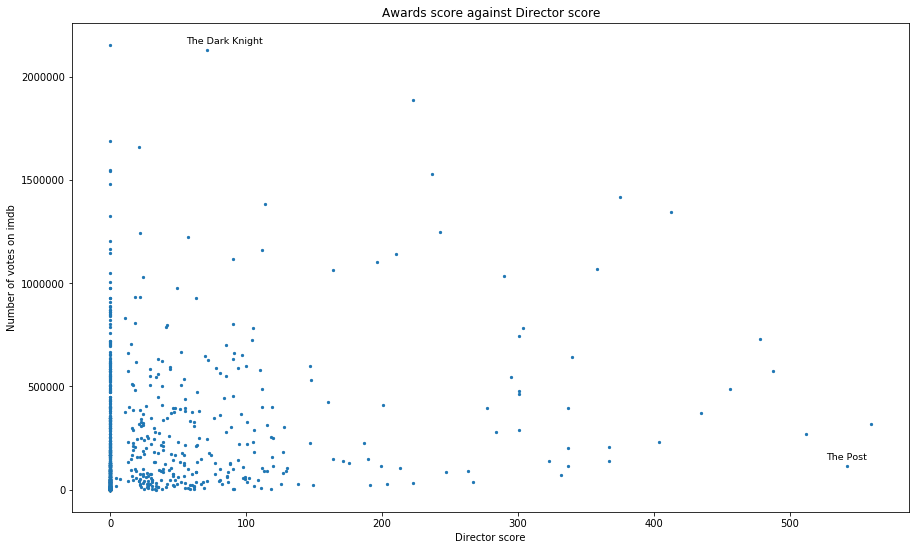

In [600]:
fig = plt.figure(figsize=(15,9))

plt.scatter(top_recognition['director_score'],\
            top_recognition['numVotes'], s=5);
plt.title("Number of votes against Director score") 

annotations = []
annotations.append(top_recognition[(top_recognition['numVotes'] > 2000000) &\
                                   (top_recognition['director_score'] > 0)]
                 [['primaryTitle', 'director_score', 'numVotes']].values)
annotations.append(top_recognition[(top_recognition['numVotes'] < 150000) &\
                                   (top_recognition['director_score'] > 500)]\
                 [['primaryTitle', 'director_score', 'numVotes']].values)

annotations = [item for sublist in annotations for item in sublist]

for title, x, y in annotations:
    plt.text(x-15, y + 35000, title, fontsize=9.5)

plt.xlabel('Director score')
plt.ylabel('Number of votes on imdb');

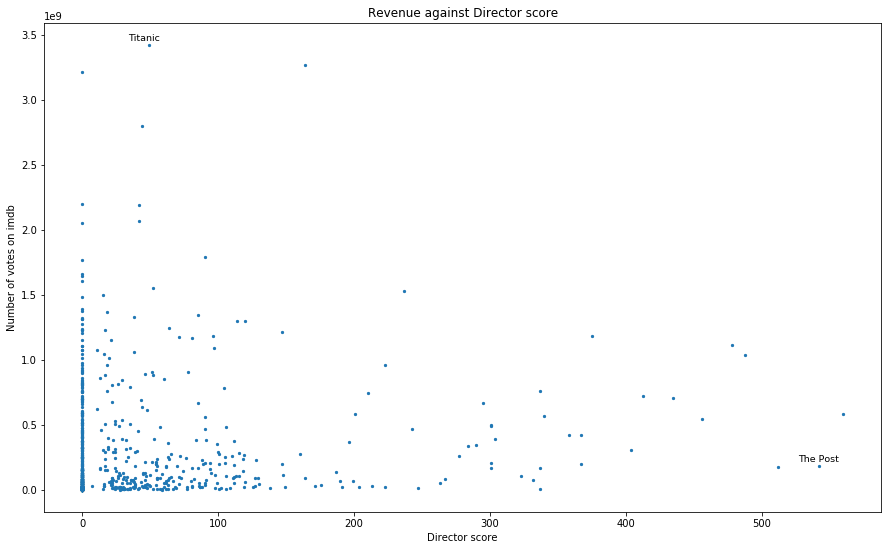

In [608]:
fig = plt.figure(figsize=(15,9))

plt.scatter(top_recognition['director_score'],\
            top_recognition['worldwideGross_adjusted'], s=5);
plt.title("Revenue against Director score") 

annotations = []
annotations.append(top_recognition[(top_recognition['worldwideGross_adjusted'] > 3.4*10**9) &\
                                   (top_recognition['director_score'] > 0)]
                 [['primaryTitle', 'director_score', 'worldwideGross_adjusted']].values)
annotations.append(top_recognition[(top_recognition['worldwideGross_adjusted'] < 5*10**8) &\
                                   (top_recognition['director_score'] > 530)]\
                 [['primaryTitle', 'director_score', 'worldwideGross_adjusted']].values)

annotations = [item for sublist in annotations for item in sublist]

for title, x, y in annotations:
    plt.text(x-15, y + 35000000, title, fontsize=9.5)

plt.xlabel('Director score')
plt.ylabel('Number of votes on imdb');

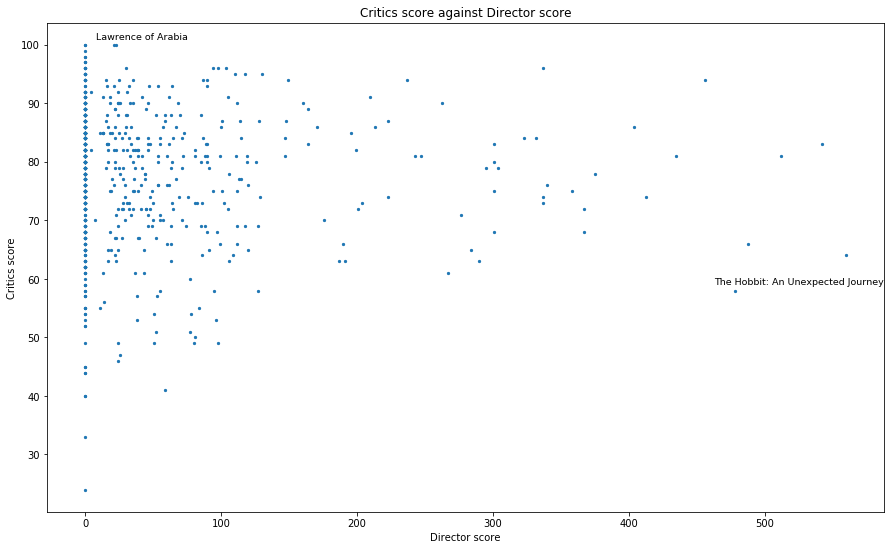

In [627]:
fig = plt.figure(figsize=(15,9))

plt.scatter(top_recognition['director_score'],\
            top_recognition['metascore'], s=5);
plt.title("Critics score against Director score") 

annotations = []
annotations.append(top_recognition[(top_recognition['metascore'] < 60) &\
                                   (top_recognition['director_score'] > 450)]
                 [['primaryTitle', 'director_score', 'metascore']].values)

annotations.append(top_recognition[(top_recognition['metascore'] == 100) &\
                                   (top_recognition['director_score'] > 22)]
                 [['primaryTitle', 'director_score', 'metascore']].values)

annotations = [item for sublist in annotations for item in sublist]

for title, x, y in annotations:
    plt.text(x-15, y + 1, title, fontsize=9.5)

plt.xlabel('Director score')
plt.ylabel('Critics score');

## Release Month

In [459]:
recognized_movies['month'] = recognized_movies.apply(lambda x: np.nan if (x['releaseDate'] == None) else \
                                                     x['releaseDate'].month , axis=1)

In [499]:
year_month_old = recognized_movies[(recognized_movies['year'] > 1930) & (recognized_movies['year'] <= 1974)]\
                .groupby(['month','year']).sum()

year_month_recent = recognized_movies[(recognized_movies['year'] > 1974) & (recognized_movies['year'] <= 2018)]\
                .groupby(['month','year']).sum()

year_month_world = recognized_movies[(recognized_movies['year'] >= 1960) & (recognized_movies['year'] <= 2018)]\
                .groupby(['month','year']).sum()

In [461]:
year_month_old_recognition = year_month_old.pivot_table(index='year', columns='month'\
                                                     , values='recognition').fillna(0)

year_month_recent_recognition = year_month_recent.pivot_table(index='year', columns='month'\
                                                     , values='recognition').fillna(0)

year_month_old_numVotes = year_month_old.pivot_table(index='year', columns='month'\
                                                        , values='numVotes').fillna(0)

year_month_recent_numVotes = year_month_recent.pivot_table(index='year', columns='month'\
                                                        , values='numVotes').fillna(0)

year_month_world = year_month_world.pivot_table(index='year', columns='month',\
                                              values='worldwideGross_adjusted').fillna(0)

year_month_old_metascore = year_month_old.pivot_table(index='year', columns='month',\
                                                values='metascore').fillna(0)

year_month_recent_metascore = year_month_recent.pivot_table(index='year', columns='month',\
                                                values='metascore').fillna(0)

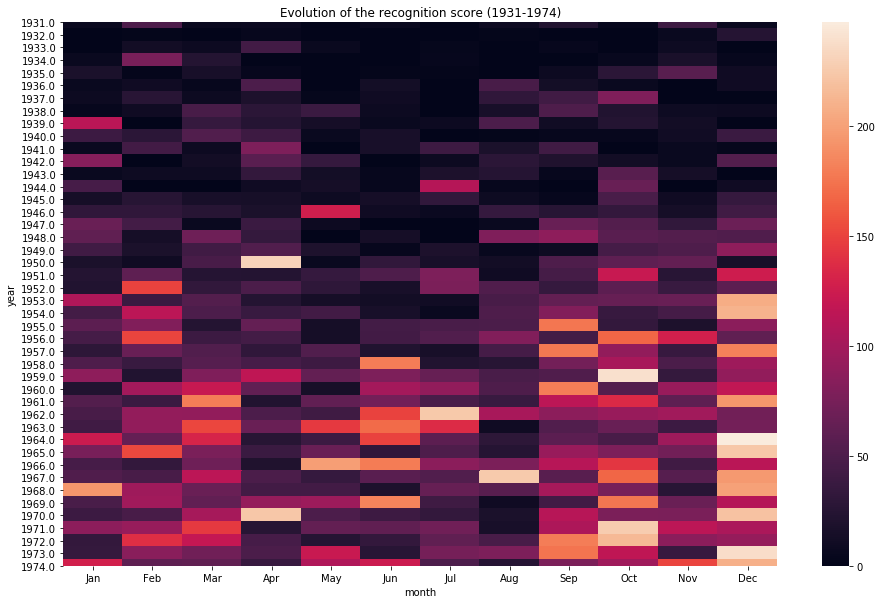

In [506]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_old_recognition.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_old_recognition,ax=ax)
plt.title('Evolution of the recognition score (1931-1974)');

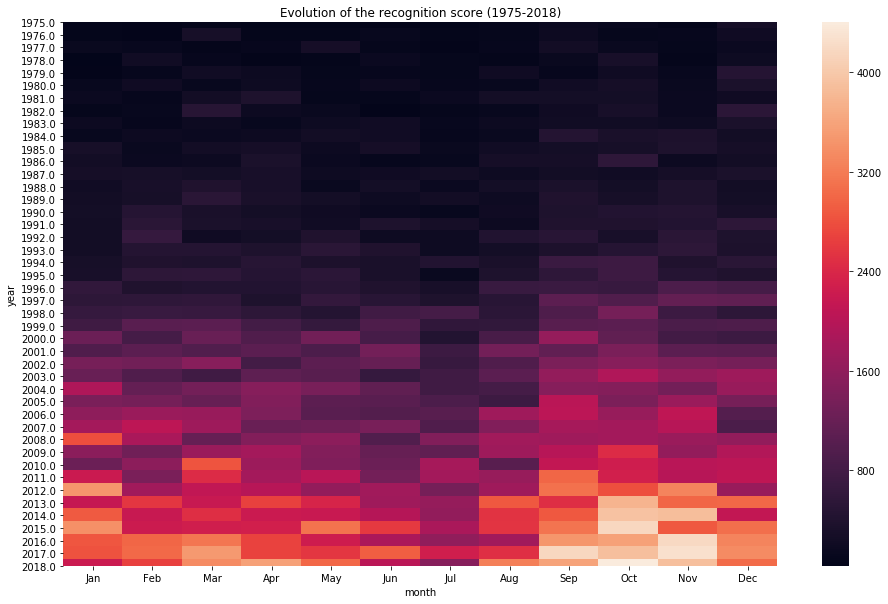

In [478]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_recent_recognition.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_recent_recognition,ax=ax)
plt.title('Evolution of the recognition score (1975-2018)');

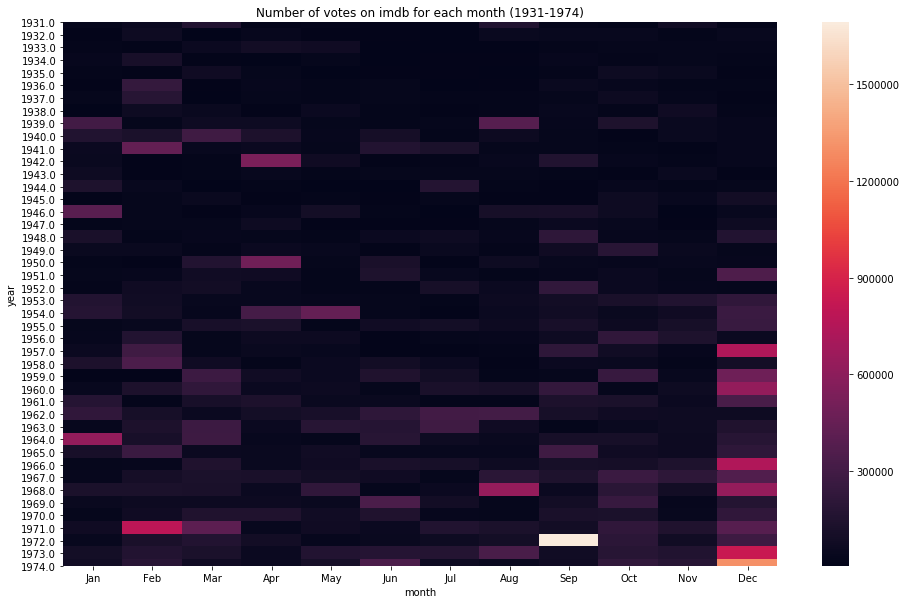

In [509]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_old_numVotes.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_old_numVotes,ax=ax)
plt.title('Number of votes on imdb for each month (1931-1974)');

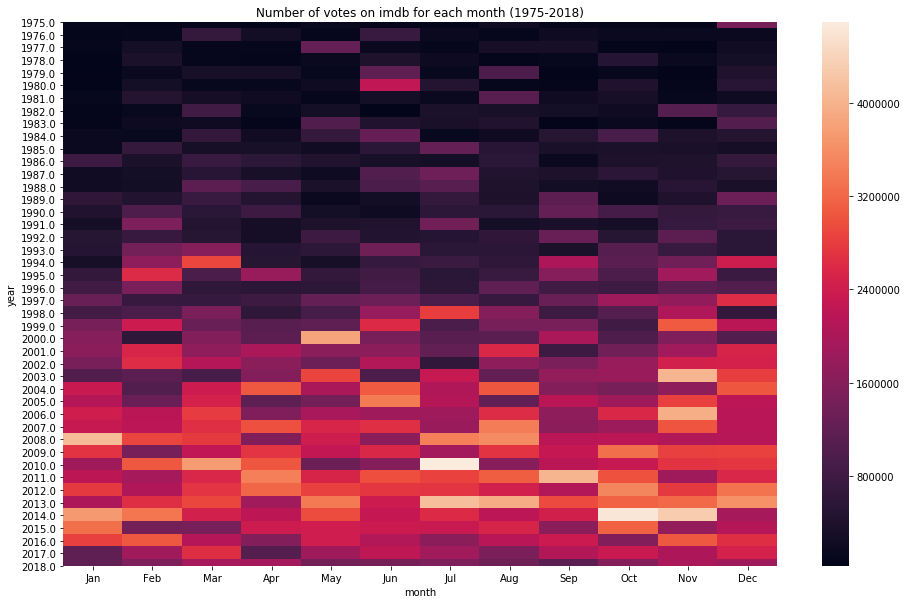

In [510]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_recent_numVotes.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_recent_numVotes,ax=ax)
plt.title('Number of votes on imdb for each month (1975-2018)');

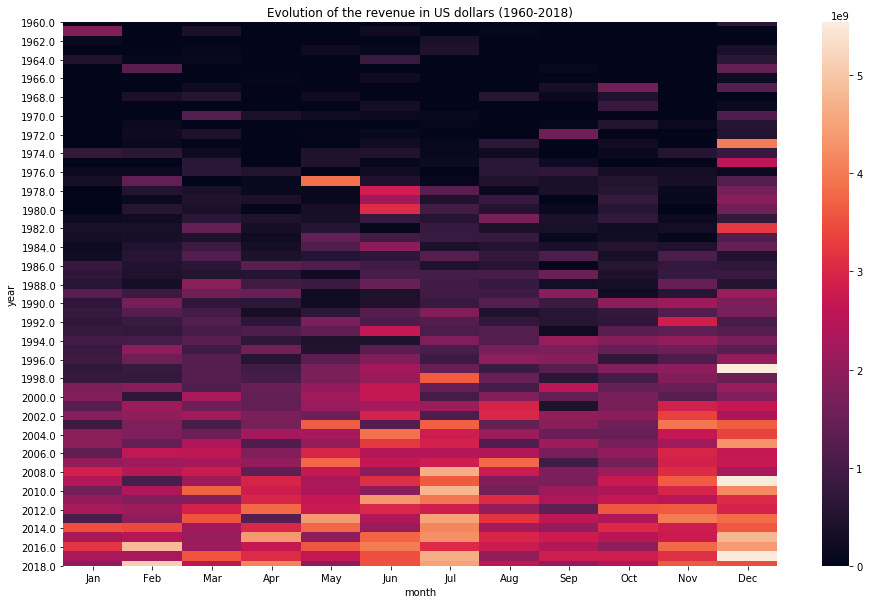

In [501]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_world.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_world,ax=ax)
plt.title('Evolution of the revenue in US dollars (1960-2018)');

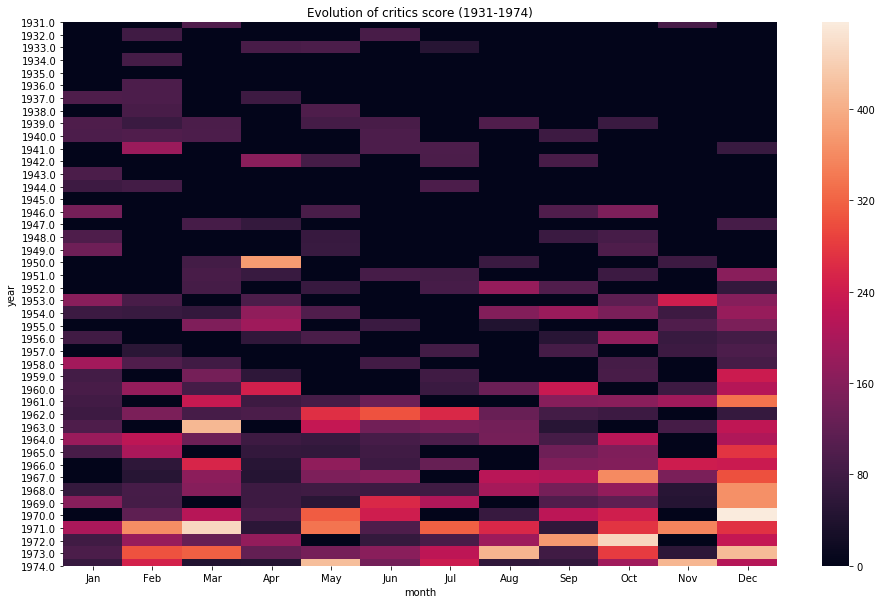

In [508]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_old_metascore.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_old_metascore,ax=ax)
plt.title('Evolution of critics score (1931-1974)');

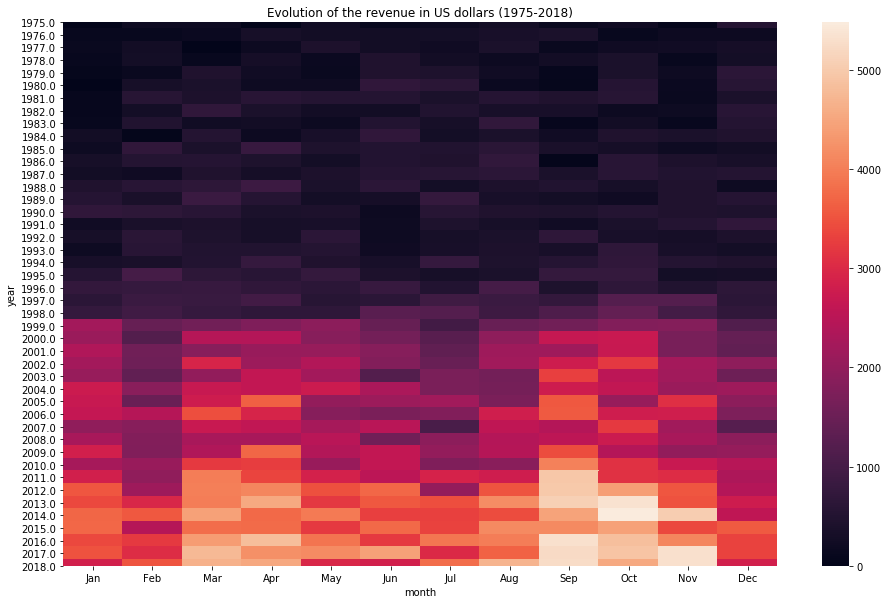

In [507]:
fig, ax = plt.subplots(figsize=(16,10)) 
year_month_recent_metascore.rename(columns={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True);

sns.heatmap(year_month_recent_metascore,ax=ax)
plt.title('Evolution of critics score (1975-2018)');

In [520]:
month_success = recognized_movies.groupby('month')['recognition', 'numVotes', \
                                                   'worldwideGross_adjusted', 'metascore']\
                 .agg([ np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

month_success = month_success.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99'})

month_success.rename(index={1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',\
                          7.0:'Jul',8.0:'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}, inplace=True)

In [532]:
month_success['recognition']

,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99
month,,,,,,,,,,,
Jan,1.763982,13.420058,0.0,559.0,0.0,"[1.629, 1.898]","[0.0, 0.0]",0.0,2.0,8.0,29.65
Feb,1.994639,14.049522,0.0,836.0,0.0,"[1.849, 2.159]","[0.0, 0.0]",0.0,4.0,9.0,32.00
Mar,1.833339,10.309568,0.0,517.0,0.0,"[1.736, 1.932]","[0.0, 0.0]",0.0,4.0,10.0,33.00
Apr,1.703201,7.840291,0.0,252.0,0.0,"[1.627, 1.782]","[0.0, 0.0]",0.0,4.0,10.0,32.00
May,1.766493,10.206639,0.0,744.0,0.0,"[1.659, 1.876]","[0.0, 0.0]",0.0,4.0,10.0,34.00
Jun,1.672463,8.797741,0.0,318.0,0.0,"[1.577, 1.769]","[0.0, 0.0]",0.0,4.0,9.0,33.00
Jul,1.622753,9.327025,0.0,552.0,0.0,"[1.522, 1.725]","[0.0, 0.0]",0.0,3.0,9.0,31.00
Aug,1.860046,10.346620,0.0,556.0,0.0,"[1.747, 1.977]","[0.0, 0.0]",0.0,4.0,10.0,37.00
Sep,2.107077,9.243044,0.0,327.0,0.0,"[2.027, 2.201]","[0.0, 0.0]",0.0,5.0,12.0,36.00


In [533]:
month_success['numVotes']

,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99
month,,,,,,,,,,,
Jan,3866.303518,29317.844566,5.0,859967.0,66.0,"[3464.589, 4269.457]","[63.0, 68.0]",375.0,2191.1,7420.10,95707.26
Feb,4450.950157,35009.607629,5.0,1166368.0,67.0,"[3952.247, 4946.169]","[65.0, 70.0]",380.0,2359.0,9174.20,101729.92
Mar,3927.786493,33182.768603,5.0,2153889.0,64.0,"[3547.072, 4330.658]","[62.0, 67.0]",372.0,2220.8,7217.80,96436.12
Apr,3353.879459,27327.096844,5.0,1204895.0,66.0,"[3023.547, 3710.996]","[63.0, 68.0]",351.0,2007.0,6680.50,77556.30
May,4107.913010,35220.213742,5.0,1243489.0,63.0,"[3655.292, 4604.844]","[61.0, 66.0]",337.0,2162.8,7472.80,81276.88
Jun,4836.644183,38528.777608,5.0,1549912.0,62.0,"[4288.871, 5398.703]","[59.0, 64.0]",347.0,2320.2,9337.40,115634.28
Jul,5264.357884,43136.061327,5.0,1887822.0,69.0,"[4637.864, 5946.544]","[66.0, 72.0]",398.0,2674.9,10196.75,114643.65
Aug,4425.419820,34396.288411,5.0,2126738.0,72.0,"[3970.361, 4910.009]","[69.0, 75.0]",437.0,2928.0,10851.80,104407.60
Sep,3279.570665,29810.213731,5.0,1657560.0,68.0,"[2933.238, 3672.14]","[66.0, 71.0]",377.0,2080.4,6749.80,71572.92


In [534]:
month_success['worldwideGross_adjusted']

,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99
month,,,,,,,,,,,
Jan,1.782002e+07,6.451581e+07,3.05,1.814742e+09,630379.595,"[16116504.027, 19708571.665]","[561786.35, 707396.27]",6.241611e+06,3.932955e+07,1.052625e+08,2.876883e+08
Feb,2.299454e+07,8.310451e+07,27.30,1.346913e+09,957113.850,"[20631105.242, 25390511.295]","[860286.29, 1062894.05]",8.165813e+06,4.669303e+07,1.170795e+08,4.220881e+08
Mar,1.876082e+07,7.090271e+07,43.03,1.294384e+09,482696.405,"[16928583.577, 20636484.195]","[435916.438, 541968.95]",4.564558e+06,3.694317e+07,1.030332e+08,3.357375e+08
Apr,1.810682e+07,9.403512e+07,0.00,2.797801e+09,488878.705,"[15726980.571, 20485358.733]","[421301.19, 546867.767]",4.861967e+06,3.437961e+07,8.253150e+07,2.958562e+08
May,2.447594e+07,1.220849e+08,108.06,3.213030e+09,327700.550,"[20981551.174, 27967851.922]","[291890.375, 365375.92]",3.401811e+06,2.691799e+07,8.745845e+07,6.678781e+08
Jun,3.038205e+07,1.218796e+08,26.92,1.790959e+09,447621.990,"[26725692.677, 34196345.193]","[392494.76, 497232.15]",4.611659e+06,4.954396e+07,1.758398e+08,6.158213e+08
Jul,3.561992e+07,1.318205e+08,52.25,1.655677e+09,731622.830,"[31481688.679, 39852457.304]","[650920.741, 834469.659]",8.062596e+06,7.228292e+07,1.882443e+08,7.454014e+08
Aug,2.217862e+07,7.727181e+07,30.72,1.172052e+09,786264.000,"[20112033.716, 24298171.732]","[693413.025, 893506.41]",8.073921e+06,4.817927e+07,1.067588e+08,4.139969e+08
Sep,1.451472e+07,6.681441e+07,2.05,1.548296e+09,398880.550,"[12796451.572, 16217920.503]","[363975.14, 438439.444]",3.357534e+06,2.587866e+07,6.818178e+07,2.766028e+08


In [535]:
month_success['metascore']

,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99
month,,,,,,,,,,,
Jan,57.337329,17.954601,1.0,99.0,58.0,"[56.484, 58.144]","[57.0, 59.0]",71.0,80.0,85.0,94.00
Feb,56.565789,18.706210,7.0,100.0,57.0,"[55.583, 57.517]","[55.0, 58.0]",71.0,81.0,86.0,94.00
Mar,57.940678,17.524441,3.0,100.0,59.0,"[57.191, 58.691]","[58.0, 60.0]",71.0,79.0,84.0,92.85
Apr,56.711876,17.175275,1.0,100.0,58.0,"[55.993, 57.492]","[57.0, 59.0]",70.0,78.0,82.0,91.00
May,57.368377,17.387943,1.0,100.0,58.0,"[56.557, 58.206]","[58.0, 60.0]",70.0,79.0,84.0,90.00
Jun,57.177626,17.235103,1.0,96.0,59.0,"[56.332, 58.033]","[58.0, 60.5]",70.0,78.0,83.0,91.00
Jul,55.927189,17.163508,1.0,100.0,57.0,"[55.049, 56.724]","[56.0, 58.0]",69.0,77.0,81.0,91.00
Aug,56.067078,17.908960,1.0,100.0,58.0,"[55.226, 56.874]","[56.0, 59.0]",70.0,78.4,83.0,90.04
Sep,57.457379,17.403076,1.0,100.0,59.0,"[56.667, 58.18]","[58.0, 60.0]",70.0,78.0,83.0,90.00


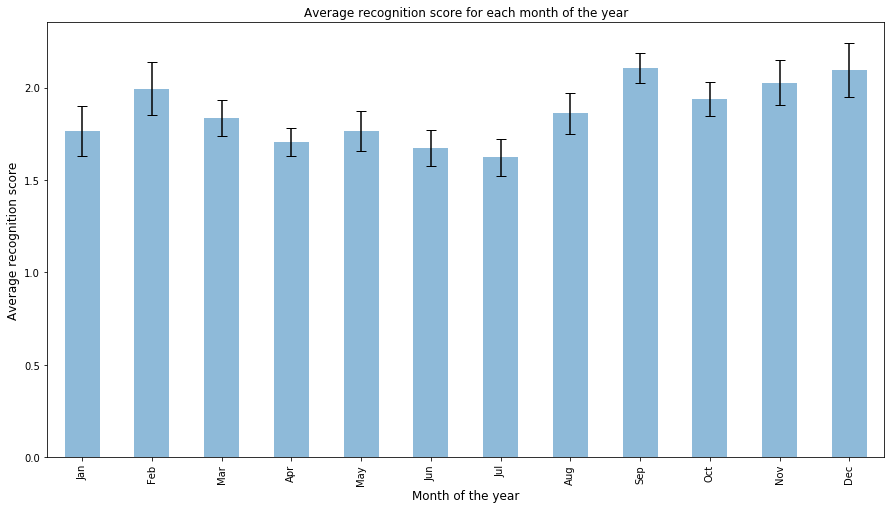

In [536]:
month_success_rec = month_success['recognition']

month_success_rec['errlo']  = month_success_rec['nanmean'] - \
                                 month_success_rec['95% CI mean'].apply(lambda x: x[0])

month_success_rec['errhi']  = month_success_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 month_success_rec['nanmean']

month_success_rec.plot(kind='bar', y='nanmean', yerr=month_success_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Month of the year", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each month of the year", size= "large");

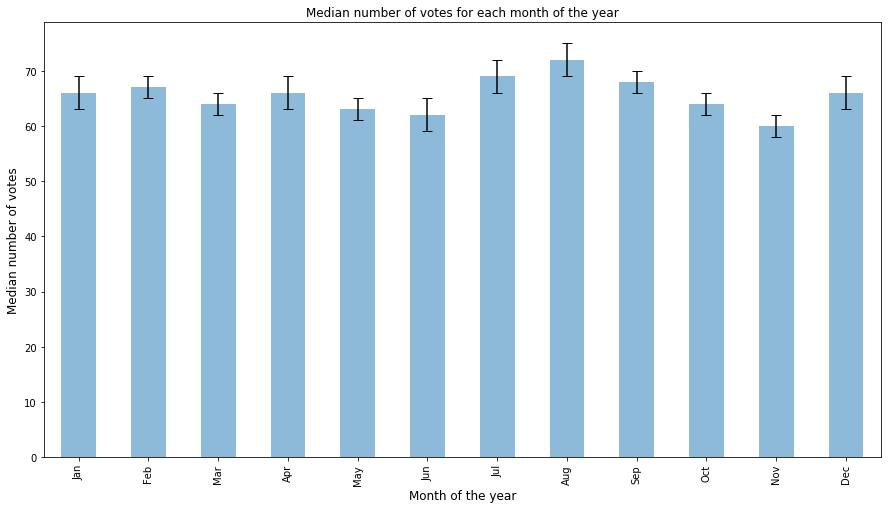

In [538]:
month_success_num = month_success['numVotes']
month_success_num['errlo']  = month_success_num['nanmedian'] - \
                                 month_success_num['95% CI median'].apply(lambda x: x[0])

month_success_num['errhi']  = month_success_num['95% CI median'].apply(lambda x: x[1]) -\
                                 month_success_num['nanmedian']

month_success_num.plot(kind='bar', y='nanmedian', yerr=month_success_num[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Month of the year", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes for each month of the year", size= "large");

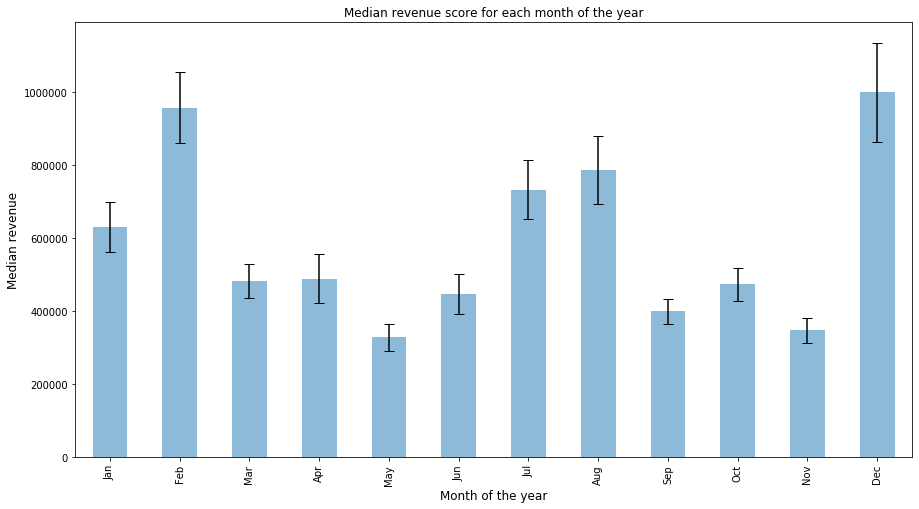

In [540]:
month_success_rev = month_success['worldwideGross_adjusted']
month_success_rev['errlo']  = month_success_rev['nanmedian'] - \
                                 month_success_rev['95% CI median'].apply(lambda x: x[0])

month_success_rev['errhi']  = month_success_rev['95% CI median'].apply(lambda x: x[1]) -\
                                 month_success_rev['nanmedian']

month_success_rev.plot(kind='bar', y='nanmedian', yerr=month_success_rev[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Month of the year", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue score for each month of the year", size= "large");

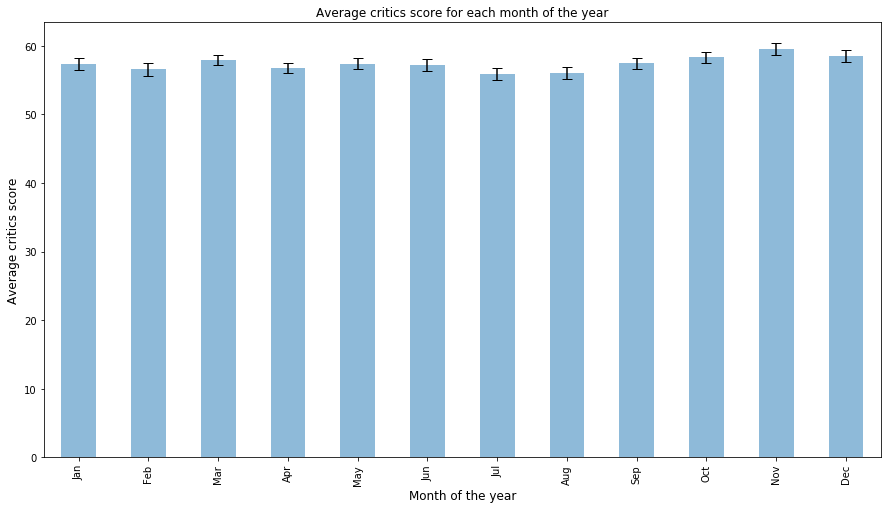

In [541]:
month_success_met = month_success['metascore']
month_success_met['errlo']  = month_success_met['nanmean'] - \
                                 month_success_met['95% CI mean'].apply(lambda x: x[0])

month_success_met['errhi']  = month_success_met['95% CI mean'].apply(lambda x: x[1]) -\
                                 month_success_met['nanmean']

month_success_met.plot(kind='bar', y='nanmean', yerr=month_success_met[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Month of the year", size='large')
plt.ylabel("Average critics score", size="large")
plt.title("Average critics score for each month of the year", size= "large");